# General Linear Model for depth features 

## import environment and load data

### environment setup

In [1]:
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import os 

import pandas as pd
import numpy as np
from scipy import stats
import scipy.spatial.distance as sp_distance
from sklearn.svm import NuSVC
import PIL.Image
from scipy.io import savemat, loadmat
from sklearn.decomposition import PCA, IncrementalPCA
# from skimage import io, transform

import nibabel as nib
import nilearn as nil
from nilearn.input_data import NiftiMasker,  MultiNiftiMasker
import glob
from nilearn.image import concat_imgs, index_img

import matplotlib.pyplot as plt
import copy

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision
from torch import nn

import glob
import pickle
from time import sleep
from datetime import datetime
from einops import rearrange

%autosave 5
%matplotlib inline
# %matplotlib widget

project_dir="/media/statespace/Spatial/sptialworkspace/spatialfMRI/fMRI_analysis/igeo_process"
fMRI_data_dir="/media/statespace/Spatial/sptialworkspace/spatialfMRI/fMRI_data/spatialfMRI_nii"

preprocessed_dir=project_dir+"/preprocess/preprocessed/afni_2023"
processed_dir=project_dir+"/process/processed"

num_runs = 14
num_TRs = 223
num_midlayer_units = 8
num_layer_pca_components = 20
num_deeplayers_units = num_midlayer_units + 12*num_layer_pca_components
num_semantic_categories = 10

start_fixation_TRs = 3
hemodynamic_shift_TRs = 3
num_TRs_video = 200

# debug1
glm_show_alpha = False

# shuffle times
shuffle_num_times = 100

# from 2nd part
num_total_dims = 1409

/home/statespace/anaconda3/envs/mybrainiak/lib/python3.6/site-packages/nilearn/__init__.py:69: FutureWarning: Python 3.6 support is deprecated and will be removed in release 0.10 of Nilearn. Consider switching to Python 3.8 or 3.9.
  _python_deprecation_warnings()


Autosaving every 5 seconds


### data preparation

##### load design matrix

In [2]:
from scipy.io import loadmat

project_dir="/media/statespace/Spatial/sptialworkspace/spatialfMRI/fMRI_analysis/igeo_process"
processed_dir=project_dir+"/process/processed/autoencoder"
file_dir = os.path.join(processed_dir, "design_matrix")

matdic = loadmat(os.path.join(file_dir, "design_matrix_alltowns_vit_pca_deeplayers_12layer_20_1latent_8.mat"))

design_matrix_alltowns = matdic["design_matrix_alltowns"]
print("design matrix for all towns (n_TRs, n_latent_units) =", design_matrix_alltowns.shape)

if(np.isnan(design_matrix_alltowns).any()):
    print("design_matrix_alltowns contain NaN values")
    
## may not add zscore
design_matrix_alltowns = stats.zscore(design_matrix_alltowns, axis=0)

if(np.isnan(design_matrix_alltowns).any()):
    print("design_matrix_alltowns contain NaN values")

design matrix for all towns (n_TRs, n_latent_units) = (1784, 269)


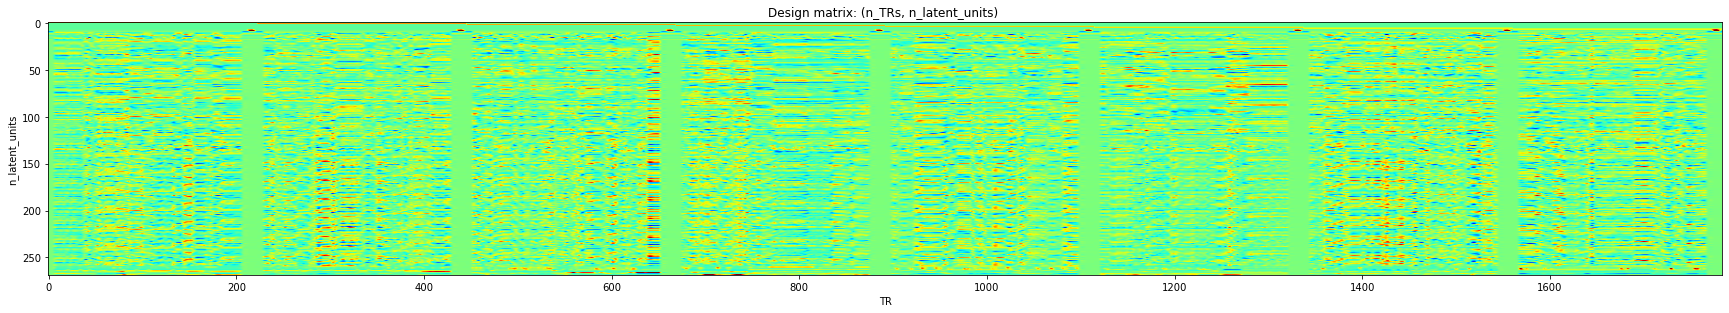

In [3]:
plt.figure(figsize=(30, 20))
plt.title('Design matrix: (n_TRs, n_latent_units) ')
plt.xlabel('TR')
plt.ylabel('n_latent_units')
plt.imshow(design_matrix_alltowns.T, cmap='jet', vmin=-5, vmax=5)
# plt.colorbar()

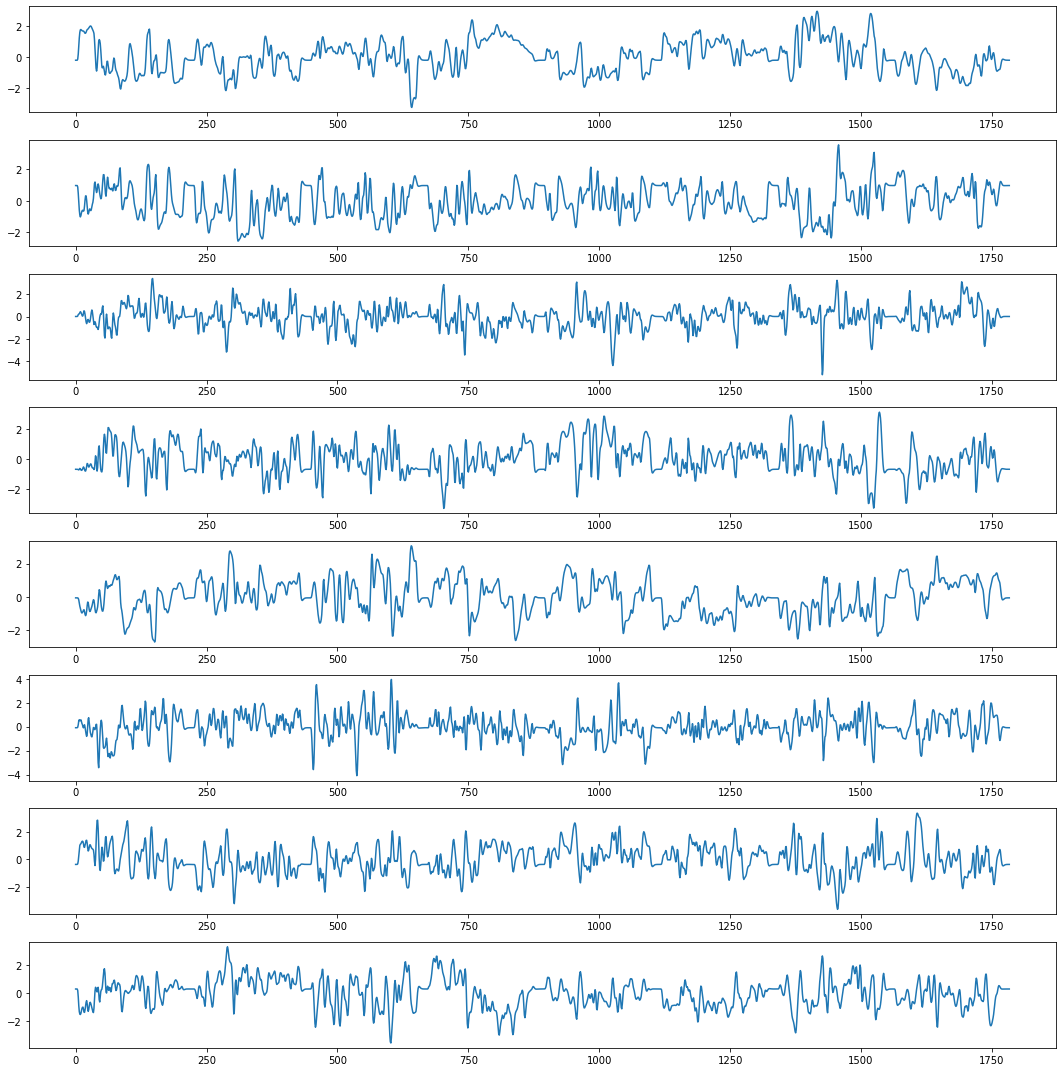

In [4]:
# check midlayer units
temp_data_ = design_matrix_alltowns[:,-(num_deeplayers_units+num_semantic_categories):]
temp_data = temp_data_[:,0:num_midlayer_units]

n = temp_data.shape[1]
fig, axs = plt.subplots(n, 1,figsize=(15,15))
for i in range(n):
    tmp = temp_data[:,i]
    axs[i].plot(np.arange(len(tmp)), tmp)
    # axs[i].xaxis.set_ticks(np.arange(0, 200, 25) * 1.5)

fig.tight_layout()
plt.show()

##### load shared response

In [5]:
# shared response with SRM feature dimensions determined by number of voxels in each region
from scipy.io import loadmat

file_dir = project_dir+"/process/depth/temp_data/"
matdic = loadmat(file_dir+"vit_"+ str(num_total_dims) + "_dims" +"_semgeo_shared_glm_list_optimal_hard_threshold.mat")

semgeo_shared_glm_list = matdic["semgeo_shared_glm_list"]
semgeo_shared_glm_list = semgeo_shared_glm_list[0]
print("shared response (shared_features, n_TRs) =", semgeo_shared_glm_list[0].shape)


shared response (shared_features, n_TRs) = (35, 3122)


In [6]:
# zscore shared response - non-effective
from scipy import stats

for i_brain_region in range(len(semgeo_shared_glm_list)):
  semgeo_shared_glm_list[i_brain_region] = stats.zscore(semgeo_shared_glm_list[i_brain_region], axis=1)

  if(np.isnan(semgeo_shared_glm_list[i_brain_region]).any()):
      print("semgeo_shared_glm_list[i_brain_region] contain NaN values")

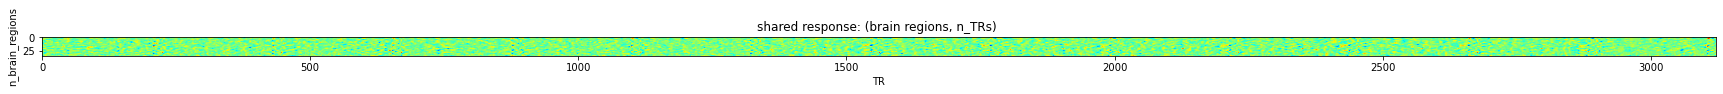

In [7]:
plt.figure(figsize=(30, 20))
plt.title('shared response: (brain regions, n_TRs) ')
plt.xlabel('TR')
plt.ylabel('n_brain_regions')
plt.imshow(semgeo_shared_glm_list[0], cmap='jet', vmin=-5, vmax=5)
# plt.colorbar()

## the encoding model of geometry representations

### train the middle layer geometry model


#### split training and testing data

In [8]:
# take only one run for one town
num_run = 14
num_towns = 8

Y_train_list = []
Y_test_list = []

# take one run as test
for i_test_run in np.arange(num_towns):

  # spliting into train and test data
  Y_train_regions_list = []
  Y_test_regions_list = []
  Y_train_regions_array = np.empty((1400,0), float)
  Y_test_regions_array = np.empty((200,0), float)

  for i_region in range(0, len(semgeo_shared_glm_list)):

    temp_shared_response = semgeo_shared_glm_list[i_region]

    Y_data_temp = rearrange(temp_shared_response, 'i (j k) -> i j k', j=num_run)

    Y_data_array = np.concatenate((Y_data_temp[:,0:7,start_fixation_TRs+hemodynamic_shift_TRs:start_fixation_TRs+hemodynamic_shift_TRs+num_TRs_video], 
              Y_data_temp[:,num_run-1:num_run,start_fixation_TRs+hemodynamic_shift_TRs:start_fixation_TRs+hemodynamic_shift_TRs+num_TRs_video]), axis=1)

    Y_train = Y_data_array[:,np.arange(num_towns)!=i_test_run,:]
    Y_test = Y_data_array[:,np.arange(num_towns)==i_test_run,:]

    Y_train = rearrange(Y_train, 'i j k -> i (j k) ')
    Y_test = rearrange(Y_test, 'i j k -> i (j k) ')

    Y_train = Y_train.T
    Y_test = Y_test.T

    Y_train_regions_array = np.append(Y_train_regions_array, Y_train, axis=1)
    Y_test_regions_array = np.append(Y_test_regions_array, Y_test, axis=1)

  Y_train_list.append(Y_train_regions_array)
  Y_test_list.append(Y_test_regions_array)

print("Y_train (n_TRs, shared_features) =", Y_train.shape)
print("Y_test (n_TRs, shared_features) =", Y_test.shape)

print("Y_train_regions_array (n_TRs, n_regions*shared_features) =", Y_train_regions_array.shape)
print("Y_test_regions_array (n_TRs, n_regions*shared_features) =", Y_test_regions_array.shape)

if(np.isnan(Y_train_regions_array).any()):
    print("Y_test_regions_array contain NaN values")

if(np.isnan(Y_test_regions_array).any()):
    print("Y_test_regions_array contain NaN values")

Y_train (n_TRs, shared_features) = (1400, 6)
Y_test (n_TRs, shared_features) = (200, 6)
Y_train_regions_array (n_TRs, n_regions*shared_features) = (1400, 1409)
Y_test_regions_array (n_TRs, n_regions*shared_features) = (200, 1409)


In [9]:
X_data_temp = []
for i_run in np.arange(num_towns):
    data_temp = design_matrix_alltowns[223*i_run:223*(i_run+1),-(num_deeplayers_units+num_semantic_categories):] # first 8, last num_semantic_categories
    data_temp = data_temp[start_fixation_TRs+hemodynamic_shift_TRs:start_fixation_TRs+hemodynamic_shift_TRs+num_TRs_video, 0:num_midlayer_units]
    X_data_temp.append(data_temp)

X_data_temp = np.asarray(X_data_temp)

X_train_list = []
X_test_list = []

for i_test_run in np.arange(num_towns):

    X_train = X_data_temp[np.arange(num_towns)!=i_test_run,:,:]
    X_test = X_data_temp[np.arange(num_towns)==i_test_run,:,:]

    X_train = rearrange(X_train, 'i j k -> (i j) k')
    X_test = rearrange(X_test, 'i j k -> (i j) k')

    X_train_list.append(X_train)
    X_test_list.append(X_test)

    if(np.isnan(X_train).any()):
        print("X_train contain NaN values")

    if(np.isnan(X_test).any()):
        print("X_test contain NaN values")

print("X_train (n_TRs, n_latent_units) =", X_train.shape)
print("X_test (n_TRs, n_latent_units) =", X_test.shape)


X_train (n_TRs, n_latent_units) = (1400, 8)
X_test (n_TRs, n_latent_units) = (200, 8)


#### fit the model

In [10]:
score_subs_list = []
Y_test_orig_list = []
Y_test_pred_list = []
model_kernel_ridgecv_list = []

for i_test_run in np.arange(num_towns):

    print("i_run:",i_test_run)
    
    # get X data
    X_train = X_train_list[i_test_run]
    X_test = X_test_list[i_test_run]

    # get Y data
    Y_train = Y_train_list[i_test_run]
    Y_test = Y_test_list[i_test_run]

    # import
    from sklearn.model_selection import check_cv
    from voxelwise_tutorials.utils import generate_leave_one_run_out

    # indice of first sample of each run
    run_onsets = []
    num_run_train=7
    for i in range(num_run_train):
        run_onsets.append(i*num_TRs_video)
    # print(run_onsets)

    n_samples_train = X_train.shape[0]
    cv = generate_leave_one_run_out(n_samples_train, run_onsets)
    cv = check_cv(cv)  # copy the cross-validation splitter into a reusable list

    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler(with_mean=False, with_std=False)

    from voxelwise_tutorials.delayer import Delayer
    delayer = Delayer(delays=[0])

    from himalaya.kernel_ridge import KernelRidgeCV
    from himalaya.ridge import RidgeCV
    from himalaya.backend import set_backend
    backend = set_backend("torch_cuda", on_error="warn")
    # print(backend)

    X_train = X_train.astype("float32")
    X_test = X_test.astype("float32")

    alphas = np.logspace(0, 20, 120)
    kernel_ridge_cv = RidgeCV(
        alphas=alphas, cv=cv, fit_intercept=True,
        solver_params=None) # try None

    from sklearn.pipeline import make_pipeline
    pipeline = make_pipeline(
        scaler,
        delayer,
        kernel_ridge_cv,
    )
    from sklearn import set_config
    set_config(display='diagram')  # requires scikit-learn 0.23
    _ = pipeline.fit(X_train, Y_train)

    # test
    scores = pipeline.score(X_test, Y_test)
    scores = backend.to_numpy(scores)
    score_subs_list.append(scores)

    # predict
    Y_test_predicted = pipeline.predict(X_test)
    Y_test_orig_list.append(Y_test)
    Y_test_pred_list.append(Y_test_predicted)

    # append ridgecv
    model_kernel_ridgecv_list.append(pipeline)

    # plot best alphas
    if glm_show_alpha == True:
        from himalaya.viz import plot_alphas_diagnostic
        import matplotlib.pyplot as plt
        best_alphas = backend.to_numpy(pipeline[-1].best_alphas_)
        print('best_alphas:',best_alphas.shape)
        plot_alphas_diagnostic(best_alphas=best_alphas, alphas=alphas)
        plt.show()

score_subs_array = np.array(score_subs_list)
print("score_subs_array.shape:",score_subs_array.shape)

Y_test_orig_midlayer_geometry = np.asarray(Y_test_orig_list)
print("Y_test_orig_midlayer_geometry.shape:",Y_test_orig_midlayer_geometry.shape)

Y_test_pred_midlayer_geometry = np.asarray(Y_test_pred_list)
print("Y_test_pred_midlayer_geometry.shape:",Y_test_pred_midlayer_geometry.shape)


i_run: 0
i_run: 1
i_run: 2
i_run: 3
i_run: 4
i_run: 5
i_run: 6
i_run: 7
score_subs_array.shape: (8, 1409)
Y_test_orig_midlayer_geometry.shape: (8, 200, 1409)
Y_test_pred_midlayer_geometry.shape: (8, 200, 1409)


#### visualize the results

##### explainable variance of regions' dims

score shape: (8, 1409)


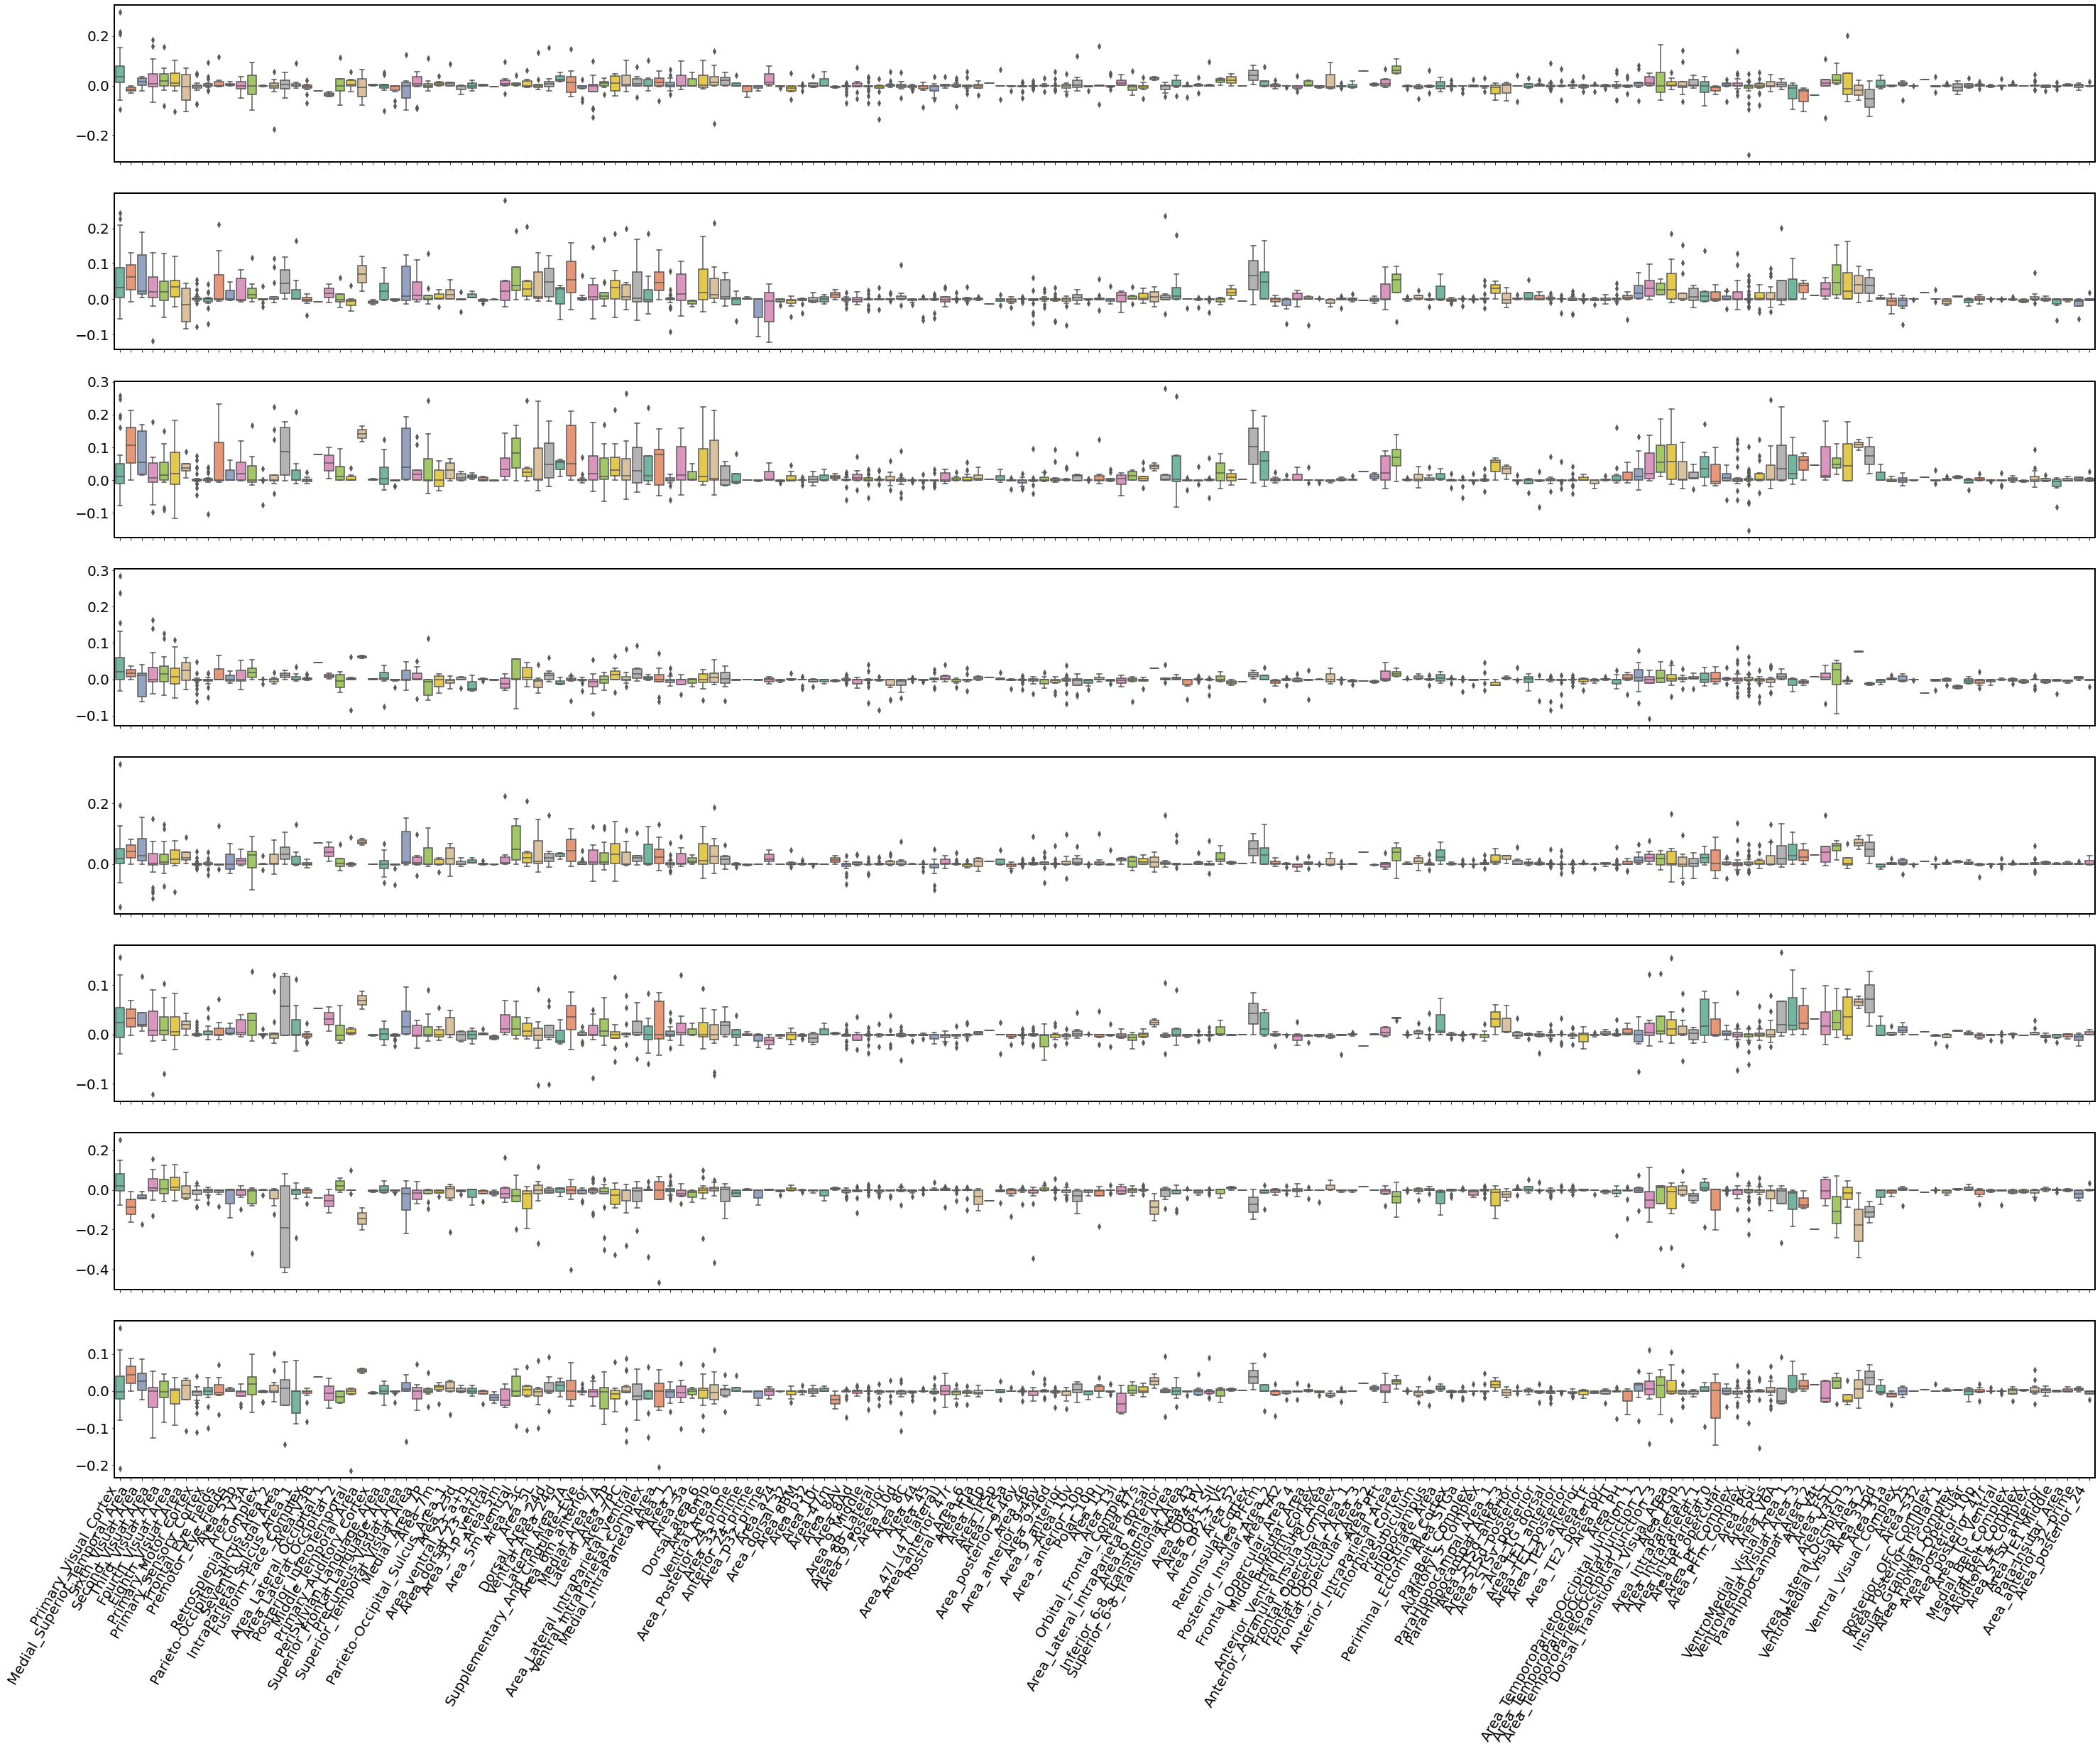

In [16]:
temp_plot_score_regions_array = copy.deepcopy(score_subs_array)
print('score shape:',temp_plot_score_regions_array.shape)

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

fig, axes = plt.subplots(nrows=temp_plot_score_regions_array.shape[0], ncols=1, figsize=(50, 60))
# fig.suptitle("Scores on test data", fontsize=18)
plt.rcParams['font.size'] = 20
plt.rcParams['axes.linewidth'] = 2
# plt.xlabel('Brain regions', fontsize=24)
# plt.ylabel('Scores', fontsize=16)

for i, ax in zip(range(temp_plot_score_regions_array.shape[0]), axes.flat):
    temp_plot_score_regions_list = []
    dim_accumulation = 0
    for i_region in range(0, len(brain_region_name_list)):
        dim_features = region_voxels_array[i_region]
        current_region_scores = temp_plot_score_regions_array[i, dim_accumulation:dim_accumulation + dim_features]
        dim_accumulation = dim_accumulation + dim_features
        # current_region_scores[current_region_scores < -0.05] = -0.05
        temp_plot_score_regions_list.append(current_region_scores)
        
    boxplt = sns.boxplot(data=temp_plot_score_regions_list, palette="Set2", ax=ax)
    boxplt.set_xticklabels([])
ax.set_xticklabels(brain_region_name_list)
plt.xticks(rotation=60, ha='right')
plt.subplots_adjust(bottom=0.4)
plt.show()

# fig.savefig('img/'+'semgeo_whole_brain_regions_test_glm_score.png', format='png', dpi=500)


##### explainable variance of dims

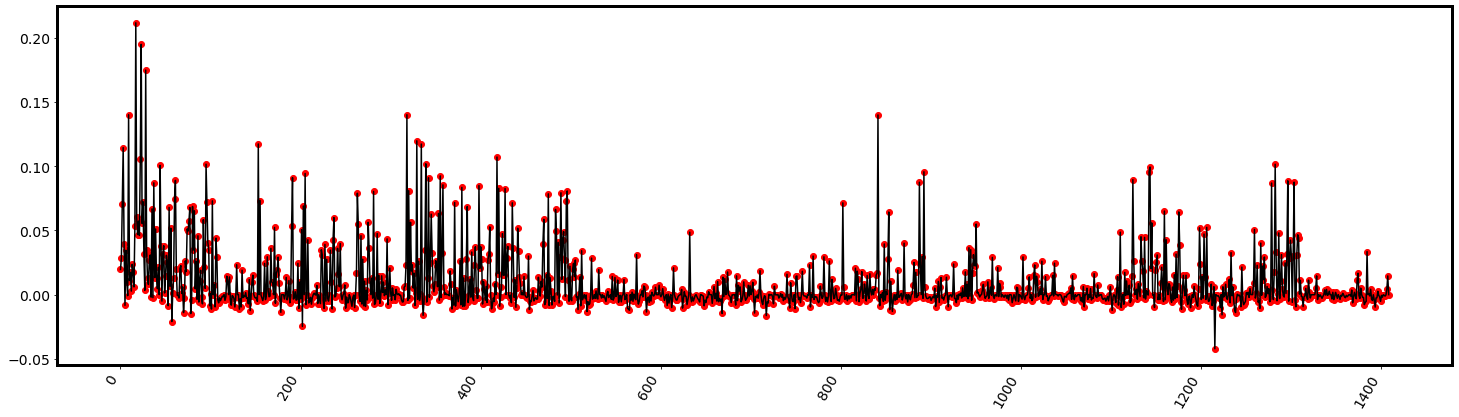

In [17]:
from sklearn.metrics import r2_score

# ve for each brain regions
dim_accumulation = 0
sub_score = np.zeros((Y_test_pred_midlayer_geometry.shape[2],), dtype=float)

for i_dim in range(0, Y_test_pred_midlayer_geometry.shape[2]):

    error = 0
    var = 0
    for i_test_run in np.arange(num_towns):

        Y_test = Y_test_orig_list[i_test_run]
        Y_test_predicted = Y_test_pred_list[i_test_run]

        y_true = Y_test[:, i_dim:i_dim + 1]
        y_pred = Y_test_predicted[:, i_dim:i_dim + 1]
        
        # error = error + ((y_true - y_pred) ** 2.0).sum()
        # var = var + ((y_true - y_true.mean(0)) ** 2.0).sum()

        error = error + (np.var(y_true - y_pred) ).sum()
        var = var + (np.var(y_true - y_true.mean(0)) ).sum()


    # dim_accumulation = dim_accumulation + dim_features

    sub_score[i_dim] = 1.0 - error / var
    
# show summary ev runs
explained_variance_single_dim_midlayer_geometry = copy.deepcopy(np.asarray(sub_score))

plt.rcParams['font.size'] = 14
plt.rcParams['axes.linewidth'] = 3
fig = plt.figure(figsize =(25, 6))
plt.plot(np.arange(0,Y_test_pred_midlayer_geometry.shape[2]), explained_variance_single_dim_midlayer_geometry,'ro')
plt.plot(np.arange(0,Y_test_pred_midlayer_geometry.shape[2]), explained_variance_single_dim_midlayer_geometry,'k-')
# plt.xticks(np.arange(0,len(brain_region_name_list)), brain_region_name_list, rotation='vertical', fontsize=8)
plt.xticks(rotation=60, ha='right')
# plt.margins(0.01)
plt.subplots_adjust(bottom=0.05)
plt.show()
# fig.savefig('img/'+'shared_ae-whole_brain_regions_glm_score.eps', format='eps', dpi=900)
# fig.savefig('img/'+'semgeo_shared_ae-whole_brain_regions_glm_score.png', dpi=500)


In [18]:
from scipy.io import savemat
import copy

print("explained_variance_single_dim_midlayer_geometry shape:", explained_variance_single_dim_midlayer_geometry.shape)

matdic = {"explained_variance_single_dim_midlayer_geometry": explained_variance_single_dim_midlayer_geometry}
project_dir="/media/statespace/Spatial/sptialworkspace/spatialfMRI/fMRI_analysis/igeo_process"

file_dir = project_dir+"/process/depth/temp_data/"
savemat(file_dir+"vit_"+ str(num_total_dims) + "_dims"+ "_single_dim_midlayer_geometry_ev_score_brain_regions.mat", matdic)

print("num of effective dims:", np.sum(explained_variance_single_dim_midlayer_geometry > 0.0))


explained_variance_single_dim_midlayer_geometry shape: (1409,)
num of effective dims: 548


#### explainable variance 

##### ev on cross all runs

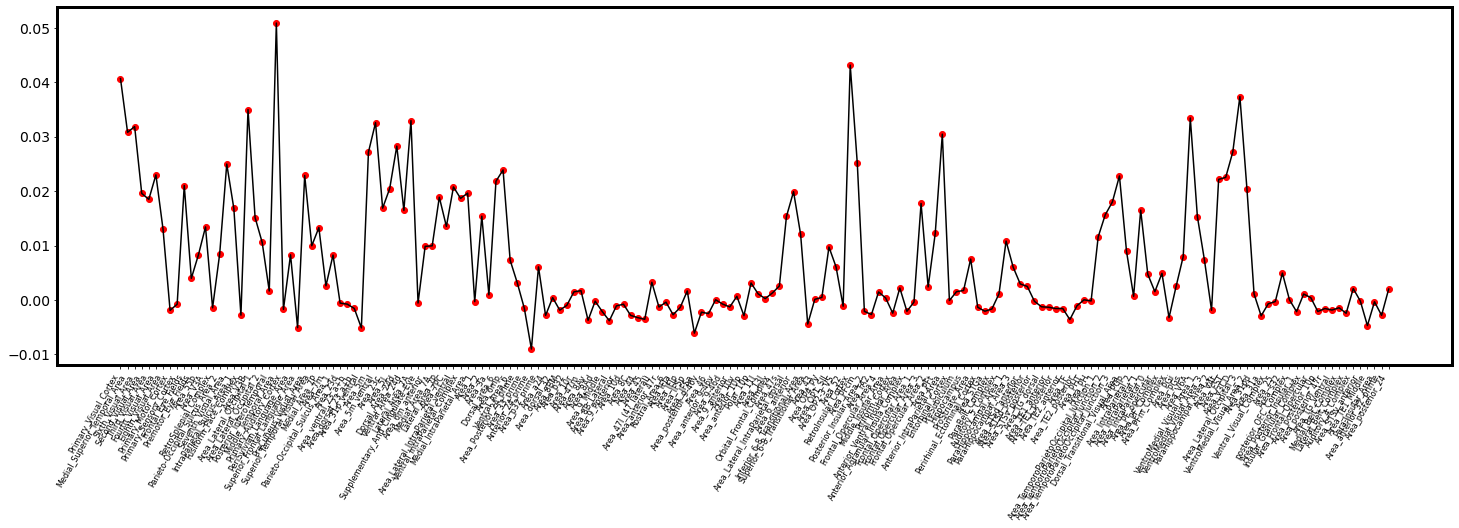

In [20]:
from sklearn.metrics import r2_score

# ve for each brain regions
dim_accumulation = 0
sub_score = np.zeros((len(brain_region_name_list),), dtype=float)

for i_region in range(0, len(brain_region_name_list)):
    dim_features = region_voxels_array[i_region]

    error = 0
    var = 0
    for i_test_run in np.arange(num_towns):

        Y_test = Y_test_orig_list[i_test_run]
        Y_test_predicted = Y_test_pred_list[i_test_run]

        y_true = Y_test[:, dim_accumulation:dim_accumulation + dim_features]
        y_pred = Y_test_predicted[:, dim_accumulation:dim_accumulation + dim_features]
        
        # error = error + ((y_true - y_pred) ** 2.0).sum()
        # var = var + ((y_true - y_true.mean(0)) ** 2.0).sum()

        error = error + (np.var(y_true - y_pred) ).sum()
        var = var + (np.var(y_true - y_true.mean(0)) ).sum()

    dim_accumulation = dim_accumulation + dim_features

    # each_sub_score[i_region] = r2_score(y_true, y_pred)
    # error = ((y_true - y_pred) ** 2.0).sum()
    # var = ((y_true - y_true.mean(0)) ** 2.0).sum()
    sub_score[i_region] = 1.0 - error / var
    
# show summary ev runs
explained_variance_midlayer_geometry = copy.deepcopy(np.asarray(sub_score))

plt.rcParams['font.size'] = 14
plt.rcParams['axes.linewidth'] = 3
fig = plt.figure(figsize =(25, 6))
plt.plot(np.arange(0,len(brain_region_name_list)), explained_variance_midlayer_geometry,'ro')
plt.plot(np.arange(0,len(brain_region_name_list)), explained_variance_midlayer_geometry,'k-')
plt.xticks(np.arange(0,len(brain_region_name_list)), brain_region_name_list, rotation='vertical', fontsize=8)
plt.xticks(rotation=60, ha='right')
# plt.margins(0.01)
plt.subplots_adjust(bottom=0.05)
plt.show()
# fig.savefig('img/'+'shared_ae-whole_brain_regions_glm_score.eps', format='eps', dpi=900)
# fig.savefig('img/'+'semgeo_shared_ae-whole_brain_regions_glm_score.png', dpi=500)


##### explainable variance of dims in each region

In [21]:
thresh_hold_ev = 0.01
print(np.sum(explained_variance_midlayer_geometry > thresh_hold_ev))
selected_explained_variance_midlayer_geometry_indice = indices = [i for i, value in enumerate(explained_variance_midlayer_geometry) if value > thresh_hold_ev]
selected_brain_region_name_list = [brain_region_name_list[i] for i in selected_explained_variance_midlayer_geometry_indice]
# selected_brain_region_name_list
bool_brain_region_name_list = explained_variance_midlayer_geometry > thresh_hold_ev

53


score shape: (8, 1409)


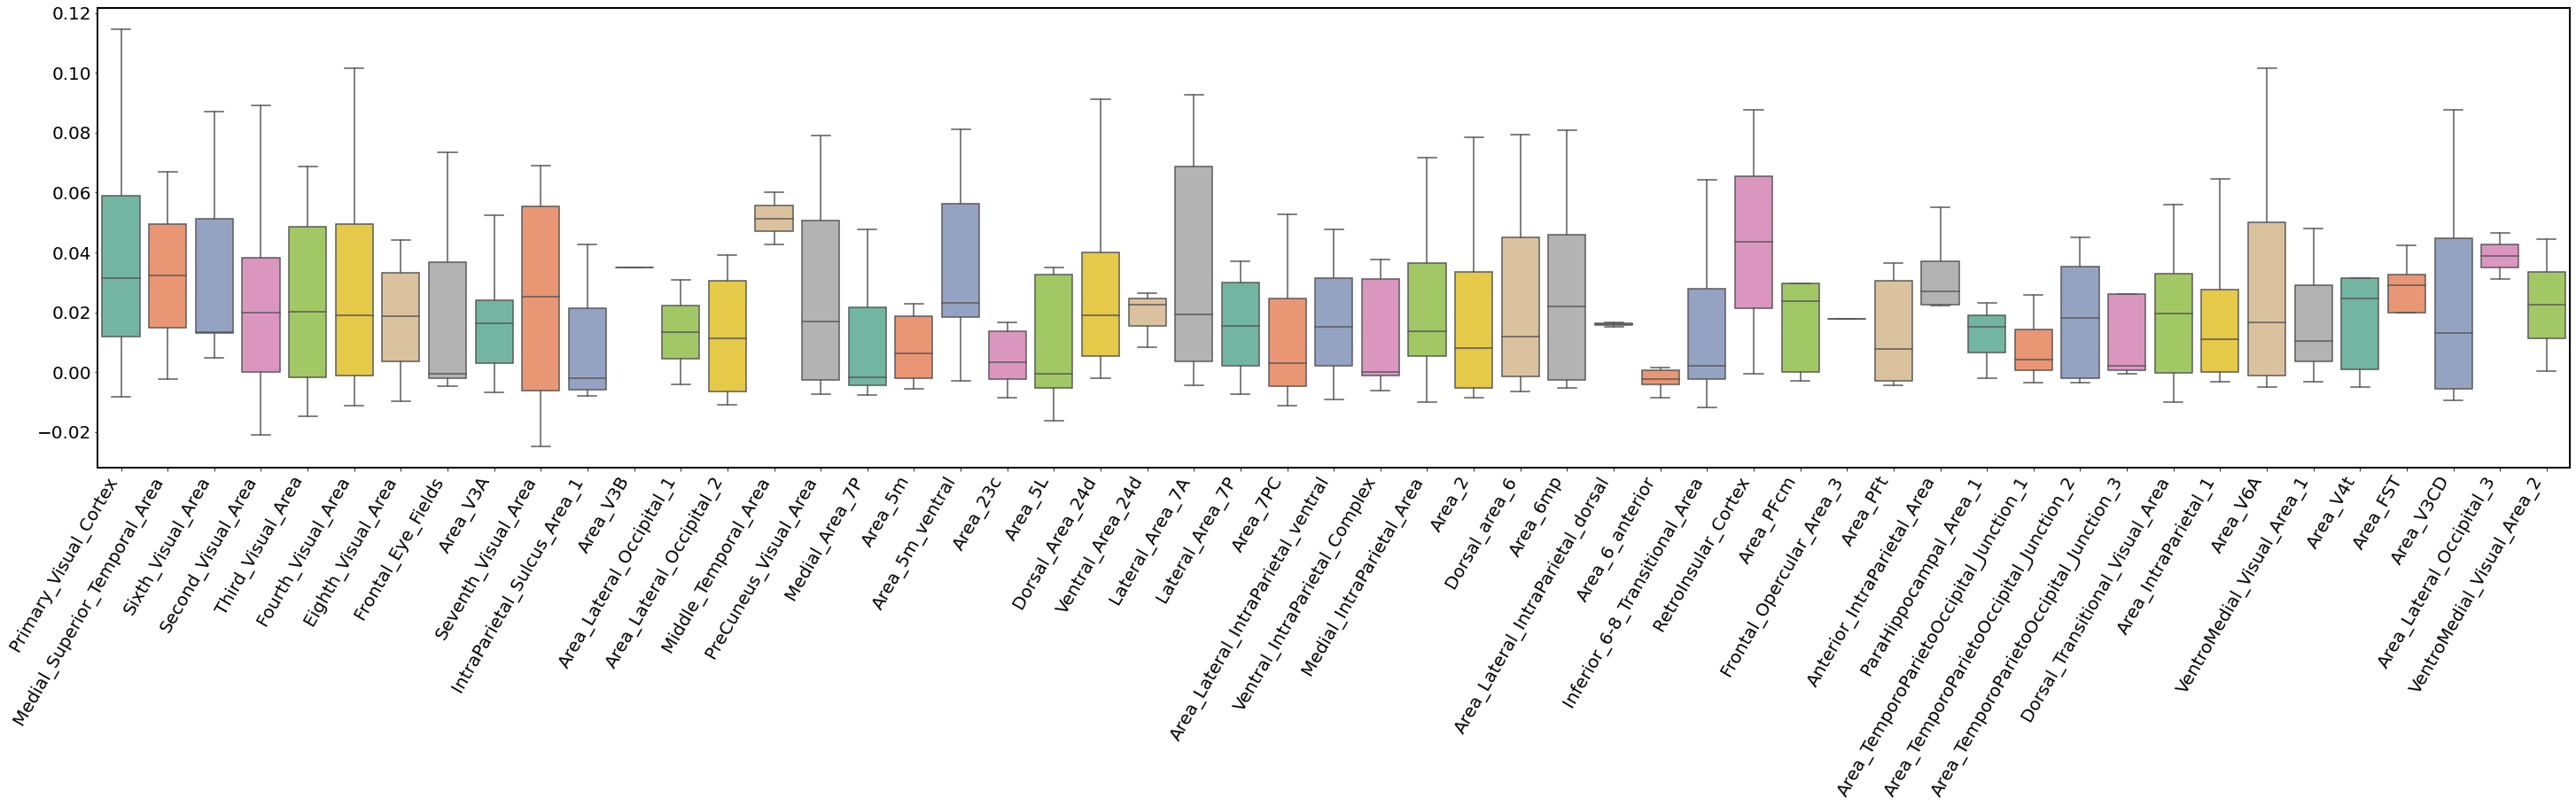

In [48]:
temp_plot_score_regions_array = copy.deepcopy(score_subs_array)
print('score shape:',temp_plot_score_regions_array.shape)

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(50, 15))
# fig.suptitle("Scores on test data", fontsize=18)
plt.rcParams['font.size'] = 20
plt.rcParams['axes.linewidth'] = 2
# plt.xlabel('Brain regions', fontsize=24)
# plt.ylabel('Scores', fontsize=16)

temp_plot_score_regions_array = np.expand_dims(explained_variance_single_dim_midlayer_geometry, axis=0)

temp_plot_score_regions_list = []
dim_accumulation = 0
for i_region in range(0, len(brain_region_name_list)):
    dim_features = region_voxels_array[i_region]
    current_region_scores = temp_plot_score_regions_array[0, dim_accumulation:dim_accumulation + dim_features]
    dim_accumulation = dim_accumulation + dim_features
    # current_region_scores[current_region_scores < -0.05] = -0.05
    if(bool_brain_region_name_list[i_region]==False): continue
    temp_plot_score_regions_list.append(current_region_scores)
    
boxplt = sns.boxplot(data=temp_plot_score_regions_list, palette="Set2", ax=ax, showfliers=False)
boxplt.set_xticklabels([])
ax.set_xticklabels(selected_brain_region_name_list)
plt.xticks(rotation=60, ha='right')
plt.subplots_adjust(bottom=0.4)
plt.show()

# fig.savefig('img/'+'semgeo_whole_brain_regions_test_glm_score.png', format='png', dpi=500)


In [49]:
from scipy.io import savemat
import copy

matdic = {
  "explained_variance_midlayer_geometry": explained_variance_midlayer_geometry,
  "explained_variance_single_dim_midlayer_geometry": explained_variance_single_dim_midlayer_geometry,
}
project_dir="/media/statespace/Spatial/sptialworkspace/spatialfMRI/fMRI_analysis/igeo_process"

file_dir = project_dir+"/process/depth/temp_data/"
savemat(file_dir+"vit_selected_midlayer_geometry_ev_score_brain_regions.mat", matdic)



#### map back to subjects for different dims
1. map back to subjects space, for each subject: $X_i = W_i * S$
2. warp subject nifti to nmi nifti
3. convert to workbench pscalar

##### 1. map back to subjects space, for each subject: $X_i = W_i * S$


In [ ]:
print("num of regions (len(srm_list)):",len(srm_list))
print("the 1st subject, v1 (voxels, dims)",srm_list[0].w_[0].shape)

In [ ]:
processed_dir=project_dir+"/process/processed"

for i_sub in np.arange(len(folder_list)):

    sub_name = folder_list[i_sub]
    sub_dir = os.path.join(processed_dir, sub_name)

    print('sub name:',sub_name)

    dim_accumulation = 0
    for i_region in range(0, len(brain_region_name_list)):

        dim_features = region_voxels_array[i_region]

        # get dims
        temp_explained_variance_single_dim = explained_variance_single_dim_midlayer_geometry[dim_accumulation:dim_accumulation + dim_features]
        
        temp_explained_variance_single_dim = np.expand_dims(temp_explained_variance_single_dim, axis=1)

        # dims to voxels
        temp_explained_variance_single_voxel = srm_list[i_region].w_[i_sub] @ temp_explained_variance_single_dim
        temp_explained_variance_single_voxel
        
        # print(temp_explained_variance_single_voxel.shape)

        # voxels to inverse mask
        brain_region_name = brain_region_name_list[i_region]
        # print('sub name:',sub_name,',brain_region_name:',brain_region_name)

        # load epi data
        run = 1
        current_file_str = 'pb04.{subject}.r{run:02}.combine+demean.nii.gz'
        current_wildcard_file_name = os.path.join(sub_dir, "shared_regions", current_file_str.format(subject=sub_name,run=run))

        current_file_name = glob.glob(current_wildcard_file_name)[0]
        epi_data = nib.load(current_file_name)
        epi_data = index_img(epi_data, 0)

        ### load mask
        mask_name = sub_name + "_" + brain_region_name+"_MNI_Glasser_HCP_neural_mask.nii.gz"
        mask_file = os.path.join(processed_dir, sub_name, "shared_regions", mask_name)

        # Load the mask image
        mask = nib.load(mask_file)

        # mask bold signal
        nifti_masker = NiftiMasker(mask_img=mask)
        masked_data = nifti_masker.fit_transform(epi_data)
        temp_masked_voxels = nifti_masker.inverse_transform(temp_explained_variance_single_voxel.T)
        if i_region == 0:
            masked_voxels = temp_masked_voxels.get_data()
        else:
            masked_voxels = masked_voxels + temp_masked_voxels.get_data()
        # print(masked_voxels.shape)

        # next region dims
        dim_accumulation = dim_accumulation + dim_features

    # save i subject
    score_nifti = nib.Nifti1Image(masked_voxels, epi_data.affine, epi_data.header)

    # Save nifti
    score_dir_out = project_dir+"/process/processed/sub-mni/"
    score_map_path = os.path.join(score_dir_out, '{subject}_explainable_variance_dims2voxel.nii.gz'.format(subject=sub_name))
    nib.save(score_nifti, score_map_path)


##### 2. warp subject nifti to nmi nifti
> warp epi to tlrc
in the directory of preprocessed subjects
- check trans \
`3dinfo sub-101_normalized_T1w_al_keep+tlrc`

- warp epi data to MNI_EPI+tlrc space \
`3dNwarpApply -nwarp './anat.un.aff.qw_WARP.nii anat.un.aff.Xat.1D' -master ~/abin/MNI_EPI+tlrc. -source pb04.sub-101.r01.combine+orig. -prefix ./pb05.101.r01.tlrc.nii.gz`

- inverse warp tlrc to epi data space \
`3dNwarpApply -iwarp -nwarp './anat.un.aff.qw_WARP.nii anat.un.aff.Xat.1D' -master ./pb04.sub-101.r01.combine+orig. -source ~/abin/MNI_Glasser_HCP_v1.0.nii.gz -prefix ./MNI_Glasser_HCP_v1.0_orig.nii.gz -interp NN`


In [ ]:
%%bash
#!/bin/bash
export PATH=$PATH:/home/statespace/abin

# warp epi data to tlrc according to the mapping from anatomy to MNI_EPI+tlrc
project_dir="/media/statespace/Spatial/sptialworkspace/spatialfMRI/fMRI_analysis/igeo_process"
cd ${project_dir}/process/processed/sub-mni

sub_list="sub-01 sub-02 sub-03 sub-04 sub-05 sub-06 sub-07 sub-08 sub-09 sub-10 sub-11 sub-12 sub-13 sub-14 sub-15 sub-16 sub-17 sub-18 sub-19 sub-20"

for sub in ${sub_list}
do

  cd ${project_dir}/preprocess/preprocessed/afni_2023/${sub}
  3dNwarpApply -nwarp './anat.un.aff.qw_WARP.nii anat.un.aff.Xat.1D' -master ~/abin/MNI_EPI+tlrc. -source ${project_dir}/process/processed/sub-mni/${sub}_explainable_variance_dims2voxel.nii.gz -prefix ${project_dir}/process/processed/sub-mni/${sub}_explainable_variance_dims2voxel_tlrc.nii.gz

done

##### 3. workbench connectome volum to surface
- http://mvpa.blogspot.com/2018/02/connectome-workbench-making-surface.html


In [ ]:
%%bash
#!/bin/bash
export PATH=$PATH:/home/statespace/abin

# warp epi data to tlrc according to the mapping from anatomy to MNI_EPI+tlrc
project_dir="/media/statespace/Spatial/sptialworkspace/spatialfMRI/fMRI_analysis/igeo_process"
cd ${project_dir}/process/processed/sub-mni

sub_list="sub-01 sub-02 sub-03 sub-04 sub-05 sub-06 sub-07 sub-08 sub-09 sub-10 sub-11 sub-12 sub-13 sub-14 sub-15 sub-16 sub-17 sub-18 sub-19 sub-20"

for sub in ${sub_list}
do

  # cd ${project_dir}/preprocess/preprocessed/afni_2023/${sub}
  # 3dNwarpApply -nwarp './anat.un.aff.qw_WARP.nii anat.un.aff.Xat.1D' -master ~/abin/MNI_EPI+tlrc. -source ${project_dir}/process/processed/sub-mni/${sub}_explainable_variance_dims2voxel.nii.gz -prefix ${project_dir}/process/processed/sub-mni/${sub}_explainable_variance_dims2voxel_tlrc.nii.gz

  /home/statespace/Downloads/workbench-linux64-v1.5.0/workbench/bin_linux64/wb_command \
    -volume-to-surface-mapping ${project_dir}/process/processed/sub-mni/${sub}_explainable_variance_dims2voxel_tlrc.nii.gz \
    /home/statespace/Downloads/Glasser_et_al_2016_HCP_MMP1.0_kN_RVVG/HCP_PhaseTwo/Q1-Q6_RelatedParcellation210/MNINonLinear/fsaverage_LR32k/Q1-Q6_RelatedParcellation210.R.inflated_MSMAll_2_d41_WRN_DeDrift.32k_fs_LR.surf.gii \
    ${project_dir}/process/processed/sub-mni/${sub}_explainable_variance_dims2voxel_tlrc.R.32k_fs_LR.shape.gii -trilinear 

  /home/statespace/Downloads/workbench-linux64-v1.5.0/workbench/bin_linux64/wb_command \
    -volume-to-surface-mapping ${project_dir}/process/processed/sub-mni/${sub}_explainable_variance_dims2voxel_tlrc.nii.gz \
    /home/statespace/Downloads/Glasser_et_al_2016_HCP_MMP1.0_kN_RVVG/HCP_PhaseTwo/Q1-Q6_RelatedParcellation210/MNINonLinear/fsaverage_LR32k/Q1-Q6_RelatedParcellation210.L.inflated_MSMAll_2_d41_WRN_DeDrift.32k_fs_LR.surf.gii \
    ${project_dir}/process/processed/sub-mni/${sub}_explainable_variance_dims2voxel_tlrc.L.32k_fs_LR.shape.gii -trilinear 

  # /home/statespace/Downloads/workbench-linux64-v1.5.0/workbench/bin_linux64/wb_command \
  #   -volume-to-surface-mapping ${project_dir}/process/processed/sub-mni/${sub}_explainable_variance_dims2voxel_tlrc.nii.gz \
  #   /home/statespace/Downloads/Glasser_et_al_2016_HCP_MMP1.0_kN_RVVG/HCP_PhaseTwo/Q1-Q6_RelatedValidation210/MNINonLinear/fsaverage_LR32k/Q1-Q6_RelatedValidation210.R.very_inflated_MSMAll_2_d41_WRN_DeDrift.32k_fs_LR.surf.gii \
  #   /home/statespace/Downloads/Glasser_et_al_2016_HCP_MMP1.0_kN_RVVG/HCP_PhaseTwo/Q1-Q6_RelatedParcellation210/MNINonLinear/fsaverage_LR32k/Q1-Q6_RelatedParcellation210.L.flat.32k_fs_LR.surf.gii \
  #   ${project_dir}/process/processed/sub-mni/${sub}_explainable_variance_dims2voxel_tlrc.L.32k_fs_LR.shape.gii -trilinear 

  # /home/statespace/Downloads/workbench-linux64-v1.5.0/workbench/bin_linux64/wb_command \
  #   -volume-to-surface-mapping ${project_dir}/process/processed/sub-mni/${sub}_explainable_variance_dims2voxel_tlrc.nii.gz \
  #   /home/statespace/Downloads/Glasser_et_al_2016_HCP_MMP1.0_kN_RVVG/HCP_PhaseTwo/Q1-Q6_RelatedValidation210/MNINonLinear/fsaverage_LR32k/Q1-Q6_RelatedValidation210.R.flat.32k_fs_LR.surf.gii \
  #   ${project_dir}/process/processed/sub-mni/${sub}_explainable_variance_dims2voxel_tlrc.32k_fs_LR.shape.gii -trilinear  
done


##### 4. get average of all subjects 


In [ ]:
processed_dir=project_dir+"/process/processed"

epi_list = []
for i_sub in np.arange(len(folder_list)):

    sub_name = folder_list[i_sub]

    # print('sub name:',sub_name)
    
    current_file_str = '{subject}_explainable_variance_dims2voxel_tlrc.nii.gz'
    current_wildcard_file_name = os.path.join(processed_dir, "sub-mni", current_file_str.format(subject=sub_name))

    current_file_name = glob.glob(current_wildcard_file_name)[0]
    epi_data = nib.load(current_file_name)
    # epi_data = index_img(epi_data, 0)

    # print("epi_data.shape:", epi_data.shape)
    tmp_epi_data = epi_data.get_data()
    tmp_epi_data[tmp_epi_data<0] = 0
    epi_list.append(tmp_epi_data)

epi_array = np.asarray(epi_list)
print("epi_array shape:", epi_array.shape)
averaged_epi_array = np.sum(epi_array, 0)
print("averaged_epi_array shape:", averaged_epi_array.shape)
print("number of NaN check:", np.sum(np.isnan(averaged_epi_array)==True))
print("averaged_epi_array max value:", np.max(averaged_epi_array)/20.0)

# save i subject
current_file_str = 'sub-01_explainable_variance_dims2voxel_tlrc.nii.gz'
current_wildcard_file_name = os.path.join(processed_dir, "sub-mni", current_file_str)

current_file_name = glob.glob(current_wildcard_file_name)[0]
epi_data = nib.load(current_file_name)

# averaged_epi_array[averaged_epi_array<0.01] = float('nan') # 0 to negative for workbench visualization
# averaged_epi_array[averaged_epi_array<0.008] = -0.008 # 0 to negative for workbench visualization
averaged_score_nifti = nib.Nifti1Image(averaged_epi_array, epi_data.affine, epi_data.header)
# averaged_score_nifti = nib.Nifti1Image(np.sum(epi_array, 0), epi_data.affine, epi_data.header)

# save nifti
sub_name = 'averaged_sub_mni'
score_dir_out = project_dir+"/process/processed/sub-mni/"
score_map_path = os.path.join(score_dir_out, '{subject}_explainable_variance_dims2voxel_tlrc.nii.gz'.format(subject=sub_name))
nib.save(averaged_score_nifti, score_map_path)

In [ ]:
%%bash
#!/bin/bash
export PATH=$PATH:/home/statespace/abin

# warp epi data to tlrc according to the mapping from anatomy to MNI_EPI+tlrc
project_dir="/media/statespace/Spatial/sptialworkspace/spatialfMRI/fMRI_analysis/igeo_process"
cd ${project_dir}/process/processed/sub-mni

sub="averaged_sub_mni"
/home/statespace/Downloads/workbench-linux64-v1.5.0/workbench/bin_linux64/wb_command \
  -volume-to-surface-mapping ${project_dir}/process/processed/sub-mni/${sub}_explainable_variance_dims2voxel_tlrc.nii.gz \
  /home/statespace/Downloads/Glasser_et_al_2016_HCP_MMP1.0_kN_RVVG/HCP_PhaseTwo/Q1-Q6_RelatedParcellation210/MNINonLinear/fsaverage_LR32k/Q1-Q6_RelatedParcellation210.R.inflated_MSMAll_2_d41_WRN_DeDrift.32k_fs_LR.surf.gii \
  ${project_dir}/process/processed/sub-mni/${sub}_explainable_variance_dims2voxel_tlrc.R.32k_fs_LR.shape.gii -trilinear 

/home/statespace/Downloads/workbench-linux64-v1.5.0/workbench/bin_linux64/wb_command \
  -volume-to-surface-mapping ${project_dir}/process/processed/sub-mni/${sub}_explainable_variance_dims2voxel_tlrc.nii.gz \
  /home/statespace/Downloads/Glasser_et_al_2016_HCP_MMP1.0_kN_RVVG/HCP_PhaseTwo/Q1-Q6_RelatedParcellation210/MNINonLinear/fsaverage_LR32k/Q1-Q6_RelatedParcellation210.L.inflated_MSMAll_2_d41_WRN_DeDrift.32k_fs_LR.surf.gii \
  ${project_dir}/process/processed/sub-mni/${sub}_explainable_variance_dims2voxel_tlrc.L.32k_fs_LR.shape.gii -trilinear 


#### cuda test

In [32]:
import torch
print(torch.cuda.is_available())
print(torch.__version__)
print(torch.version.cuda)


False
1.4.0
None


In [31]:
!conda install cudatoolkit=11.3 -c pytorch -y


Retrieving notices: ...working... done
done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 22.11.1
  latest version: 24.5.0

Please update conda by running

    $ conda update -n base -c conda-forge conda

Or to minimize the number of packages updated during conda update use

     conda install conda=24.5.0



# All requested packages already installed.



In [33]:
from himalaya.backend import set_backend
try:
    backend = set_backend("torch")  # or "torch_cuda"

    # backend = set_backend("torch_cuda", on_error="warn")
    # backend = set_backend("torch")
except ImportError:
    print("torch_cuda is not available. Falling back to numpy backend.")
    backend = set_backend("torch", on_error="warn")


#### permutation before cross-validation


##### the geometry permutation model

In [46]:
from himalaya.kernel_ridge import KernelRidgeCV
from himalaya.ridge import RidgeCV
from himalaya.backend import set_backend
backend = set_backend("torch_cuda", on_error="warn")
# print(backend)

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=False, with_std=False)
from sklearn import set_config
set_config(display='diagram')  # requires scikit-learn 0.23

# import
from sklearn.model_selection import check_cv
from voxelwise_tutorials.utils import generate_leave_one_run_out
from voxelwise_tutorials.delayer import Delayer
delayer = Delayer(delays=[0])

shuffle_num_times = 10000
# ve for each brain regions
sub_score_shuffle_list = []

Y_test_orig_permutation_list = []
Y_test_pred_permutation_list = []

sub_score = np.zeros((len(brain_region_name_list), shuffle_num_times,), dtype=float)

for i_shuffle in range(shuffle_num_times):

    np.random.seed(i_shuffle)
    single_run_TRs_video_indices = np.arange(num_TRs_video)
    X_test_indices_2 = np.arange(X_test_list[0].shape[1])
    Y_test_indices_2 = np.arange(Y_test_list[0].shape[1])
    np.random.shuffle(single_run_TRs_video_indices)

    train_run_TRs_video_indices = np.zeros(((num_towns - 1)*num_TRs_video,), dtype=int)
    for i_train_run in range(num_towns-1):
        i_run_TRs_video_indices = copy.deepcopy(single_run_TRs_video_indices)
        np.random.shuffle(i_run_TRs_video_indices)
        train_run_TRs_video_indices[i_train_run*num_TRs_video:(i_train_run+1)*num_TRs_video] \
            = i_run_TRs_video_indices + i_train_run*num_TRs_video

    if i_shuffle%1000 == 0:
        print("i_shuffle:",i_shuffle)

    i_Y_test_orig_permutation_list = []
    i_Y_test_pred_permutation_list = []

    for i_test_run in np.arange(num_towns):

        # print("i_run:",i_test_run)
        
        # get X data
        X_train = X_train_list[i_test_run]
        # X_train_permutation = X_train[train_run_TRs_video_indices[:,None], X_test_indices_2[None,:]]
        X_train_permutation = X_train

        X_test = X_test_list[i_test_run]
        # X_test_permutation = X_test[single_run_TRs_video_indices[:,None], X_test_indices_2[None,:]]
        X_test_permutation = X_test

        # get Y data
        Y_train = Y_train_list[i_test_run]
        Y_train_permutation = Y_train[train_run_TRs_video_indices[:,None], Y_test_indices_2[None,:]]

        Y_test = Y_test_list[i_test_run]
        Y_test_permutation = Y_test[single_run_TRs_video_indices[:,None], Y_test_indices_2[None,:]]

        # indice of first sample of each run
        run_onsets = []
        num_run_train=7
        for i in range(num_run_train):
            run_onsets.append(i*num_TRs_video)
        # print(run_onsets)

        n_samples_train = X_train.shape[0]
        cv = generate_leave_one_run_out(n_samples_train, run_onsets)
        cv = check_cv(cv)  # copy the cross-validation splitter into a reusable list

        X_train_permutation = X_train_permutation.astype("float32")
        X_test_permutation = X_test_permutation.astype("float32")

        alphas = np.logspace(-3, 20, 120)
        kernel_ridge_cv = RidgeCV(
            alphas=alphas, cv=cv, fit_intercept=True,
            solver_params=None) # try None

        pipeline = make_pipeline(
            scaler,
            delayer,
            kernel_ridge_cv,
        )
        _ = pipeline.fit(X_train_permutation, Y_train_permutation)

        # primal_coef = pipeline[-1].get_primal_coef()
        # primal_coef = backend.to_numpy(primal_coef)
        # print("(n_delays * n_features, n_voxels) =", primal_coef.shape)
        # print("coef mean:",np.mean(primal_coef.flatten()))

        # predict
        Y_test_permutation_predicted = pipeline.predict(X_test_permutation)
        i_Y_test_orig_permutation_list.append(Y_test_permutation)
        i_Y_test_pred_permutation_list.append(Y_test_permutation_predicted)

    # calc ev for each region in a permutation
    dim_accumulation = 0
    for i_region in range(0, len(brain_region_name_list)):

        dim_features = region_voxels_array[i_region]

        error = 0
        var = 0
        for i_test_run in np.arange(num_towns):

            Y_test = i_Y_test_orig_permutation_list[i_test_run]
            Y_test_predicted = i_Y_test_pred_permutation_list[i_test_run]

            y_true = Y_test[:, dim_accumulation:dim_accumulation + dim_features]
            y_pred = Y_test_predicted[:, dim_accumulation:dim_accumulation + dim_features].numpy()
            
            # error = error + ((y_true - y_pred) ** 2.0).sum()
            # var = var + ((y_true - y_true.mean(0)) ** 2.0).sum()

            error = error + (np.var(y_true - y_pred) ).sum()
            var = var + (np.var(y_true - y_true.mean(0)) ).sum()

        sub_score[i_region][i_shuffle] = 1.0 - error / var

        dim_accumulation = dim_accumulation + dim_features

explained_variance_each_shuffle_midlayer_geometry = copy.deepcopy(np.asarray(sub_score))
print("explained_variance_each_shuffle_midlayer_geometry shape:", explained_variance_each_shuffle_midlayer_geometry.shape)


/home/statespace/anaconda3/envs/mybrainiak/lib/python3.6/site-packages/himalaya/backend/_utils.py:56: UserWarning: Setting backend to torch_cuda failed: PyTorch with CUDA is not available..Falling back to torch backend.
  warnings.warn(f"Setting backend to {backend} failed: {str(error)}."


i_shuffle: 0
i_shuffle: 1000
i_shuffle: 2000
i_shuffle: 3000
i_shuffle: 4000
i_shuffle: 5000
i_shuffle: 6000
i_shuffle: 7000
i_shuffle: 8000
i_shuffle: 9000
explained_variance_each_shuffle_midlayer_geometry shape: (180, 10000)


In [47]:
from scipy.io import savemat
import copy

print("explained_variance_each_shuffle_midlayer_geometry shape:", explained_variance_each_shuffle_midlayer_geometry.shape)

matdic = {"explained_variance_each_shuffle_midlayer_geometry": explained_variance_each_shuffle_midlayer_geometry}
project_dir="/media/statespace/Spatial/sptialworkspace/spatialfMRI/fMRI_analysis/igeo_process"

file_dir = project_dir+"/process/depth/temp_data/"
savemat(file_dir+"vit_"+ str(num_total_dims) + "_dims"+ "_shareddims_explained_variance_each_shuffle_midlayer_geometry.mat", matdic)


explained_variance_each_shuffle_midlayer_geometry shape: (180, 10000)


In [ ]:
from scipy.io import loadmat

project_dir="/media/statespace/Spatial/sptialworkspace/spatialfMRI/fMRI_analysis/igeo_process"
file_dir = project_dir+"/process/depth/temp_data/"
matdic = loadmat(file_dir+"vit_"+ str(num_total_dims) + "_dims"+ "_shareddims_explained_variance_each_shuffle_midlayer_geometry.mat")

explained_variance_each_shuffle_midlayer_geometry = matdic["explained_variance_each_shuffle_midlayer_geometry"]
print("explained_variance_each_shuffle_midlayer_geometry shape =", explained_variance_each_shuffle_midlayer_geometry.shape)

##### permuation explainable variance (each shuffle) - calc p-values

In [ ]:
print("explained_variance_each_shuffle_midlayer_geometry.shape:",explained_variance_each_shuffle_midlayer_geometry.shape)
print("explained_variance_midlayer_geometry.shape",explained_variance_midlayer_geometry.shape)

temp_shuffle_score = copy.deepcopy(explained_variance_each_shuffle_midlayer_geometry.T)

raw_pvalue_list = []
for i_region in range(temp_shuffle_score.shape[1]):
  raw_pvalue = np.sum(temp_shuffle_score[:,i_region] > explained_variance_midlayer_geometry[i_region])
  raw_pvalue_list.append(raw_pvalue)

raw_pvalue_array = np.asarray(raw_pvalue_list)/temp_shuffle_score.shape[0]

#-----multiple test
import statsmodels

# multiple test corrected for p-values
rejects, pvals_corrected, _, _ = statsmodels.stats.multitest.multipletests(raw_pvalue_array)

num_rejects = np.sum(rejects == True)
print("num_rejects:", num_rejects)

plt.plot(pvals_corrected)
print("pvals less than:", np.sum(pvals_corrected < 0.05))

##### permuation explainable variance (each shuffle) - visualize before multipletests

In [ ]:
midlayer_geometry_sub_score_percentile = np.percentile(temp_shuffle_score, 95, axis=0)
print('sub_score_shuffle_array shape:',temp_shuffle_score.shape)

# show summary ev runs
explained_variance_midlayer_geometry_shuffle_percentile = copy.deepcopy(midlayer_geometry_sub_score_percentile)

plt.rcParams['font.size'] = 14
plt.rcParams['axes.linewidth'] = 3
fig = plt.figure(figsize =(25, 6))
plt.plot(np.arange(0,len(brain_region_name_list)), explained_variance_midlayer_geometry,'r-o')
plt.plot(np.arange(0,len(brain_region_name_list)), explained_variance_midlayer_geometry_shuffle_percentile,'k.--')
plt.xticks(np.arange(0,len(brain_region_name_list)), brain_region_name_list, rotation='vertical', fontsize=8)
plt.xticks(rotation=60, ha='right')
# plt.margins(0.01)
plt.subplots_adjust(bottom=0.05)
plt.show()
# fig.savefig('img/'+'shared_ae-whole_brain_regions_glm_score.eps', format='eps', dpi=900)
# fig.savefig('img/'+'semgeo_shared_ae-whole_brain_regions_glm_score.png', dpi=500)

##### permuation explainable variance (each shuffle) - save and load for wb

In [ ]:
from scipy.io import savemat
import copy

print("sub_score shape:", explained_variance_midlayer_geometry.shape)

if pvals_corrected is None:
  matdic = {"sub_score": explained_variance_midlayer_geometry}
else:
  matdic = {"sub_score": explained_variance_midlayer_geometry,
            "pvals_corrected": pvals_corrected}
project_dir="/media/statespace/Spatial/sptialworkspace/spatialfMRI/fMRI_analysis/igeo_process"

file_dir = project_dir+"/process/depth/temp_data/"
savemat(file_dir+"vit_"+ str(num_total_dims) + "_dims"+ "_midlayer_geometry_ev_score_brain_regions.mat", matdic)


## the decoding model of geometry representations


### train the decoding model to predict the middle layer


#### split training and testing data

In [ ]:
# take only one run for one town
num_run = 14
num_towns = 8

Y_train_list = []
Y_test_list = []

# take one run as test
for i_test_run in np.arange(num_towns):

  # spliting into train and test data
  Y_train_regions_list = []
  Y_test_regions_list = []
  Y_train_regions_array = np.empty((1400,0), float)
  Y_test_regions_array = np.empty((200,0), float)

  for i_region in range(0, len(semgeo_shared_glm_list)):

    temp_shared_response = semgeo_shared_glm_list[i_region]

    Y_data_temp = rearrange(temp_shared_response, 'i (j k) -> i j k', j=num_run)

    Y_data_array = np.concatenate((Y_data_temp[:,0:7,start_fixation_TRs+hemodynamic_shift_TRs:start_fixation_TRs+hemodynamic_shift_TRs+num_TRs_video], 
              Y_data_temp[:,num_run-1:num_run,start_fixation_TRs+hemodynamic_shift_TRs:start_fixation_TRs+hemodynamic_shift_TRs+num_TRs_video]), axis=1)

    Y_train = Y_data_array[:,np.arange(num_towns)!=i_test_run,:]
    Y_test = Y_data_array[:,np.arange(num_towns)==i_test_run,:]

    Y_train = rearrange(Y_train, 'i j k -> i (j k) ')
    Y_test = rearrange(Y_test, 'i j k -> i (j k) ')

    Y_train = Y_train.T
    Y_test = Y_test.T

    Y_train_regions_array = np.append(Y_train_regions_array, Y_train, axis=1)
    Y_test_regions_array = np.append(Y_test_regions_array, Y_test, axis=1)

  Y_train_list.append(Y_train_regions_array)
  Y_test_list.append(Y_test_regions_array)

print("Y_train (n_TRs, shared_features) =", Y_train.shape)
print("Y_test (n_TRs, shared_features) =", Y_test.shape)

print("Y_train_regions_array (n_TRs, n_regions*shared_features) =", Y_train_regions_array.shape)
print("Y_test_regions_array (n_TRs, n_regions*shared_features) =", Y_test_regions_array.shape)

if(np.isnan(Y_train_regions_array).any()):
    print("Y_test_regions_array contain NaN values")

if(np.isnan(Y_test_regions_array).any()):
    print("Y_test_regions_array contain NaN values")

In [ ]:
X_data_temp = []
for i_run in np.arange(num_towns):
    data_temp = design_matrix_alltowns[223*i_run:223*(i_run+1),-(num_deeplayers_units+num_semantic_categories):] # first 8, last num_semantic_categories
    data_temp = data_temp[start_fixation_TRs+hemodynamic_shift_TRs:start_fixation_TRs+hemodynamic_shift_TRs+num_TRs_video, 0:num_midlayer_units]
    X_data_temp.append(data_temp)

X_data_temp = np.asarray(X_data_temp)

X_train_list = []
X_test_list = []

for i_test_run in np.arange(num_towns):

    X_train = X_data_temp[np.arange(num_towns)!=i_test_run,:,:]
    X_test = X_data_temp[np.arange(num_towns)==i_test_run,:,:]

    X_train = rearrange(X_train, 'i j k -> (i j) k')
    X_test = rearrange(X_test, 'i j k -> (i j) k')

    X_train_list.append(X_train)
    X_test_list.append(X_test)

    if(np.isnan(X_train).any()):
        print("X_train contain NaN values")

    if(np.isnan(X_test).any()):
        print("X_test contain NaN values")

print("X_train (n_TRs, n_latent_units) =", X_train.shape)
print("X_test (n_TRs, n_latent_units) =", X_test.shape)


#### fit the model

In [ ]:
score_subs_list = []
X_test_orig_list = []
X_test_pred_list = []

for i_test_run in np.arange(num_towns):

    print("i_run:",i_test_run)
    
    # get X data
    X_train = X_train_list[i_test_run]
    X_test = X_test_list[i_test_run]

    # get Y data
    Y_train = Y_train_list[i_test_run]
    Y_test = Y_test_list[i_test_run]

    # import
    from sklearn.model_selection import check_cv
    from voxelwise_tutorials.utils import generate_leave_one_run_out

    # indice of first sample of each run
    run_onsets = []
    num_run_train=7
    for i in range(num_run_train):
        run_onsets.append(i*223)
    # print(run_onsets)

    n_samples_train = X_train.shape[0]
    cv = generate_leave_one_run_out(n_samples_train, run_onsets)
    cv = check_cv(cv)  # copy the cross-validation splitter into a reusable list

    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler(with_mean=True, with_std=False)

    from voxelwise_tutorials.delayer import Delayer
    delayer = Delayer(delays=[-1, 0])

    from himalaya.kernel_ridge import KernelRidgeCV
    from himalaya.backend import set_backend
    backend = set_backend("torch_cuda", on_error="warn")
    # print(backend)

    X_train = X_train.astype("float32")
    X_test = X_test.astype("float32")

    alphas = np.logspace(-3, 10, 120)
    kernel_ridge_cv = KernelRidgeCV(
        alphas=alphas, cv=cv, fit_intercept=True,
        solver_params=dict(n_targets_batch=500, n_alphas_batch=5, 
                        n_targets_batch_refit=100))

    from sklearn.pipeline import make_pipeline
    pipeline = make_pipeline(
        scaler,
        delayer,
        kernel_ridge_cv,
    )
    from sklearn import set_config
    set_config(display='diagram')  # requires scikit-learn 0.23
    _ = pipeline.fit(Y_train, X_train)

    # test
    scores = pipeline.score(Y_test, X_test)
    scores = backend.to_numpy(scores)
    score_subs_list.append(scores)

    # predict
    X_test_predicted = pipeline.predict(Y_test)
    X_test_orig_list.append(X_test)
    X_test_pred_list.append(X_test_predicted)

score_subs_array = np.array(score_subs_list)
print("score_subs_array.shape:",score_subs_array.shape)

X_test_orig_array = np.asarray(X_test_orig_list)
print("X_test_orig_array.shape:",X_test_orig_array.shape)

X_test_pred_array = np.asarray(X_test_pred_list)
print("X_test_pred_array.shape:",X_test_pred_array.shape)

#### visualize the results

##### scores on each towns

In [ ]:
temp_plot_score_regions_array = copy.deepcopy(score_subs_array)
print('score shape:',temp_plot_score_regions_array.shape)

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

town_name_list = []
for i_town in range(1,9):
  town_name_list.append("Town0"+str(i_town))

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))
fig.suptitle("Scores", fontsize=18)
plt.rcParams['font.size'] = 16
plt.rcParams['axes.linewidth'] = 2
# plt.xlabel('Brain regions', fontsize=24)
# plt.ylabel('Scores', fontsize=16)
# temp_plot_score_regions_array[temp_plot_score_regions_array<-0.3] = -0.3
boxplt = sns.boxplot(data=temp_plot_score_regions_array.T, palette="Set2", showfliers=False)
boxplt.set_xticklabels(town_name_list)
plt.subplots_adjust(bottom=0.4)
plt.show()

# fig.savefig('img/'+'leave_one_out_without_repeated_town07_latent_whole_brain_regions_glm_score.eps', format='eps', dpi=900)


##### score for all units

In [ ]:
from sklearn.metrics import r2_score

error = 0
var = 0
for i_test_run in np.arange(num_towns):

    x_true = X_test_orig_array[i_test_run,:,:]
    x_pred = X_test_pred_array[i_test_run,:,:]
    
    # error = error + ((y_true - y_pred) ** 2.0).sum()
    # var = var + ((y_true - y_true.mean(0)) ** 2.0).sum()

    error = error + (np.var(x_true - x_pred) ).sum()
    var = var + (np.var(x_true - x_true.mean(0)) ).sum()

sub_score = 1.0 - error / var
print("sub_score:",sub_score)

##### score for each unit

In [ ]:
from sklearn.metrics import r2_score

sub_score_list = []
for i_unit in range(0, X_train_list[0].shape[1]):

    error = 0
    var = 0
    for i_test_run in np.arange(num_towns):

        x_true = X_test_orig_array[i_test_run,:,i_unit]
        x_pred = X_test_pred_array[i_test_run,:,i_unit]
        
        error = error + (np.var(x_true - x_pred) ).sum()
        var = var + (np.var(x_true - x_true.mean(0)) ).sum()

    i_unit_sub_score = 1.0 - error / var
    sub_score_list.append(i_unit_sub_score)

sub_score_array = np.asarray(sub_score_list)
print("sub_score_array.shape:",sub_score_array.shape)
print("sub_score_array:",sub_score_array)

##### correlation between gt and pred

In [ ]:
for i_test_run in np.arange(num_towns):
  temp_X_test_orig_array = X_test_orig_array[i_test_run,:,:]
  temp_X_test_pred_array = X_test_pred_array[i_test_run,:,:]

  corr_X_test = np.corrcoef(temp_X_test_orig_array, temp_X_test_pred_array)
  fig = plt.figure(figsize=(5, 5))
  plt.imshow(corr_X_test, interpolation='None', cmap='coolwarm')
  plt.title('Town:'+str(i_test_run + 1))
  plt.show()

### train the masked regions decoding model to predict the middle layer


#### get mask indices
mask the regions of fMRI data, design matrix

##### get the fMRI data mask from the midlayer geometry model


In [ ]:
# get mask from the midlayer geometry model
from scipy.io import loadmat

project_dir="/media/statespace/Spatial/sptialworkspace/spatialfMRI/fMRI_analysis/igeo_process"
file_dir = project_dir+"/process/depth/temp_data/"

file_str = "vit_"+ str(num_total_dims) + "_dims"+ "_midlayer_geometry_ev_score_brain_regions"

matdic = loadmat(file_dir+file_str+".mat")
explained_variance_midlayer_geometry = matdic["sub_score"]
pvals_corrected_midlayer_geometry = matdic["pvals_corrected"]

p_value_threshold = 0.05

print("effective regions in the midlayer geometry:", np.sum(pvals_corrected_midlayer_geometry < p_value_threshold))

indices_Y_pvals_corrected_midlayer_geometry = np.squeeze(pvals_corrected_midlayer_geometry < p_value_threshold)
print(indices_Y_pvals_corrected_midlayer_geometry.shape, indices_Y_pvals_corrected_midlayer_geometry)

##### get the design matrix mask from the single unit midlayer geometry model


In [ ]:
from scipy.io import loadmat

project_dir="/media/statespace/Spatial/sptialworkspace/spatialfMRI/fMRI_analysis/igeo_process"
file_dir = project_dir+"/process/depth/temp_data/"

file_str = "vit_"+ str(num_total_dims) + "_dims" + "_single_unit_midlayer_geometry_ev_score_brain_regions"

matdic = loadmat(file_dir+file_str+".mat")
explained_variance_single_unit_midlayer_geometry = matdic["explained_variance_single_unit_midlayer_geometry"]
pvals_corrected_list_single_unit_midlayer_geometry = matdic["pvals_corrected_list"]

print("effective regions in the midlayer geometry:", np.sum(pvals_corrected_midlayer_geometry < 0.05))

num_effective_regions_single_unit_list = []
for i_unit in range(len(pvals_corrected_list_single_unit_midlayer_geometry)):

  pvals_corrected_temp = pvals_corrected_list_single_unit_midlayer_geometry[i_unit]
  i_unit_num_effective_regions = np.sum(pvals_corrected_temp < 0.05)
  print("num of effective regions::", i_unit_num_effective_regions)
  num_effective_regions_single_unit_list.append(i_unit_num_effective_regions)

num_effective_regions_single_unit_array = np.asarray(num_effective_regions_single_unit_list)
print("num_effective_regions_single_unit_array.shape:", num_effective_regions_single_unit_array.shape)

indices_X_single_unit_array = np.squeeze(num_effective_regions_single_unit_array > 10)
print(indices_X_single_unit_array)

#### split training and testing data

In [ ]:
# take only one run for one town
num_run = 14
num_towns = 8

Y_train_list = []
Y_test_list = []

# take one run as test
for i_test_run in np.arange(num_towns):

  # spliting into train and test data
  Y_train_regions_list = []
  Y_test_regions_list = []
  Y_train_regions_array = np.empty((1400,0), float)
  Y_test_regions_array = np.empty((200,0), float)

  for i_region in range(0, len(semgeo_shared_glm_list)):

    # skip the false regions
    if indices_Y_pvals_corrected_midlayer_geometry[i_region] == False: continue
    
    temp_shared_response = semgeo_shared_glm_list[i_region]

    Y_data_temp = rearrange(temp_shared_response, 'i (j k) -> i j k', j=num_run)

    Y_data_array = np.concatenate((Y_data_temp[:,0:7,start_fixation_TRs+hemodynamic_shift_TRs:start_fixation_TRs+hemodynamic_shift_TRs+num_TRs_video], 
              Y_data_temp[:,num_run-1:num_run,start_fixation_TRs+hemodynamic_shift_TRs:start_fixation_TRs+hemodynamic_shift_TRs+num_TRs_video]), axis=1)

    Y_train = Y_data_array[:,np.arange(num_towns)!=i_test_run,:]
    Y_test = Y_data_array[:,np.arange(num_towns)==i_test_run,:]

    Y_train = rearrange(Y_train, 'i j k -> i (j k) ')
    Y_test = rearrange(Y_test, 'i j k -> i (j k) ')

    Y_train = Y_train.T
    Y_test = Y_test.T

    Y_train_regions_array = np.append(Y_train_regions_array, Y_train, axis=1)
    Y_test_regions_array = np.append(Y_test_regions_array, Y_test, axis=1)

  Y_train_list.append(Y_train_regions_array)
  Y_test_list.append(Y_test_regions_array)

print("Y_train (n_TRs, shared_features) =", Y_train.shape)
print("Y_test (n_TRs, shared_features) =", Y_test.shape)

print("Y_train_regions_array (n_TRs, n_regions*shared_features) =", Y_train_regions_array.shape)
print("Y_test_regions_array (n_TRs, n_regions*shared_features) =", Y_test_regions_array.shape)

if(np.isnan(Y_train_regions_array).any()):
    print("Y_test_regions_array contain NaN values")

if(np.isnan(Y_test_regions_array).any()):
    print("Y_test_regions_array contain NaN values")

In [ ]:
X_data_temp = []
for i_run in np.arange(num_towns):
    data_temp = design_matrix_alltowns[223*i_run:223*(i_run+1),-(num_deeplayers_units+num_semantic_categories):] # first 8, last num_semantic_categories
    data_temp = data_temp[start_fixation_TRs+hemodynamic_shift_TRs:start_fixation_TRs+hemodynamic_shift_TRs+num_TRs_video, 0:num_midlayer_units]
    # data_temp = data_temp[:,indices_X_single_unit_array]
    X_data_temp.append(data_temp)

X_data_temp = np.asarray(X_data_temp)
print("X_data_temp shape:",X_data_temp.shape)

X_train_list = []
X_test_list = []

for i_test_run in np.arange(num_towns):

    X_train = X_data_temp[np.arange(num_towns)!=i_test_run,:,:]
    X_test = X_data_temp[np.arange(num_towns)==i_test_run,:,:]

    X_train = rearrange(X_train, 'i j k -> (i j) k')
    X_test = rearrange(X_test, 'i j k -> (i j) k')

    X_train_list.append(X_train)
    X_test_list.append(X_test)

    if(np.isnan(X_train).any()):
        print("X_train contain NaN values")

    if(np.isnan(X_test).any()):
        print("X_test contain NaN values")

print("X_train (n_TRs, n_latent_units) =", X_train.shape)
print("X_test (n_TRs, n_latent_units) =", X_test.shape)


#### fit the model

In [ ]:
score_subs_list = []
X_test_orig_list = []
X_test_pred_list = []

for i_test_run in np.arange(num_towns):

    print("i_run:",i_test_run)
    
    # get X data
    X_train = X_train_list[i_test_run]
    X_test = X_test_list[i_test_run]

    # get Y data
    Y_train = Y_train_list[i_test_run]
    Y_test = Y_test_list[i_test_run]

    # import
    from sklearn.model_selection import check_cv
    from voxelwise_tutorials.utils import generate_leave_one_run_out

    # indice of first sample of each run
    run_onsets = []
    num_run_train=7
    for i in range(num_run_train):
        run_onsets.append(i*223)
    # print(run_onsets)

    n_samples_train = X_train.shape[0]
    cv = generate_leave_one_run_out(n_samples_train, run_onsets)
    cv = check_cv(cv)  # copy the cross-validation splitter into a reusable list

    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler(with_mean=True, with_std=False)

    from voxelwise_tutorials.delayer import Delayer
    delayer = Delayer(delays=[-1, 0])

    from himalaya.kernel_ridge import KernelRidgeCV
    from himalaya.backend import set_backend
    backend = set_backend("torch_cuda", on_error="warn")
    # print(backend)

    X_train = X_train.astype("float32")
    X_test = X_test.astype("float32")

    alphas = np.logspace(-3, 10, 120)
    kernel_ridge_cv = KernelRidgeCV(
        alphas=alphas, cv=cv, fit_intercept=True,
        solver_params=dict(n_targets_batch=500, n_alphas_batch=5, 
                        n_targets_batch_refit=100))

    from sklearn.pipeline import make_pipeline
    pipeline = make_pipeline(
        scaler,
        delayer,
        kernel_ridge_cv,
    )
    from sklearn import set_config
    set_config(display='diagram')  # requires scikit-learn 0.23
    _ = pipeline.fit(Y_train, X_train)

    # test
    scores = pipeline.score(Y_test, X_test)
    scores = backend.to_numpy(scores)
    score_subs_list.append(scores)

    # predict
    X_test_predicted = pipeline.predict(Y_test)
    X_test_orig_list.append(X_test)
    X_test_pred_list.append(X_test_predicted)

score_subs_array = np.array(score_subs_list)
print("score_subs_array.shape:",score_subs_array.shape)

X_test_orig_array = np.asarray(X_test_orig_list)
print("X_test_orig_array.shape:",X_test_orig_array.shape)

X_test_pred_array = np.asarray(X_test_pred_list)
print("X_test_pred_array.shape:",X_test_pred_array.shape)

#### visualize the results

##### scores on each towns

In [ ]:
temp_plot_score_regions_array = copy.deepcopy(score_subs_array)
print('score shape:',temp_plot_score_regions_array.shape)

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

town_name_list = []
for i_town in range(1,9):
  town_name_list.append("Town0"+str(i_town))

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))
fig.suptitle("Scores", fontsize=18)
plt.rcParams['font.size'] = 16
plt.rcParams['axes.linewidth'] = 2
# plt.xlabel('Brain regions', fontsize=24)
# plt.ylabel('Scores', fontsize=16)
# temp_plot_score_regions_array[temp_plot_score_regions_array<-0.3] = -0.3
boxplt = sns.boxplot(data=temp_plot_score_regions_array.T, palette="Set2", showfliers=False)
boxplt.set_xticklabels(town_name_list)
plt.subplots_adjust(bottom=0.4)
plt.show()

# fig.savefig('img/'+'leave_one_out_without_repeated_town07_latent_whole_brain_regions_glm_score.eps', format='eps', dpi=900)


##### score for all units

In [ ]:
from sklearn.metrics import r2_score

error = 0
var = 0
for i_test_run in np.arange(num_towns):

    x_true = X_test_orig_array[i_test_run,:,:]
    x_pred = X_test_pred_array[i_test_run,:,:]
    
    # error = error + ((y_true - y_pred) ** 2.0).sum()
    # var = var + ((y_true - y_true.mean(0)) ** 2.0).sum()

    error = error + (np.var(y_true - y_pred) ).sum()
    var = var + (np.var(y_true - y_true.mean(0)) ).sum()

sub_score = 1.0 - error / var
print("sub_score:",sub_score)

##### score for each unit

In [ ]:
from sklearn.metrics import r2_score

sub_score_list = []
for i_unit in range(0, X_train_list[0].shape[1]):

    error = 0
    var = 0
    for i_test_run in np.arange(num_towns):

        x_true = X_test_orig_array[i_test_run,:,i_unit]
        x_pred = X_test_pred_array[i_test_run,:,i_unit]
            
        # error = error + ((y_true - y_pred) ** 2.0).sum()
        # var = var + ((y_true - y_true.mean(0)) ** 2.0).sum()

        error = error + (np.var(y_true - y_pred) ).sum()
        var = var + (np.var(y_true - y_true.mean(0)) ).sum()

    i_unit_sub_score = 1.0 - error / var
    sub_score_list.append(i_unit_sub_score)

sub_score_array = np.asarray(sub_score_list)
print("sub_score_array.shape:",sub_score_array.shape)
print("sub_score_array:",sub_score_array)

##### correlation between gt and pred

In [ ]:
for i_test_run in np.arange(num_towns):
  temp_X_test_orig_array = X_test_orig_array[i_test_run,:,:]
  temp_X_test_pred_array = X_test_pred_array[i_test_run,:,:]

  corr_X_test = np.corrcoef(temp_X_test_orig_array, temp_X_test_pred_array)
  fig = plt.figure(figsize=(5, 5))
  plt.imshow(corr_X_test, interpolation='None', cmap='coolwarm')
  plt.title('Town:'+str(i_test_run + 1))
  plt.show()

### train the town07 of masked regions decoding model to predict the middle layer


#### get mask indices
mask the regions of fMRI data, design matrix, only take the averaged town07 as the test data

##### get the fMRI data mask from the midlayer geometry model


In [ ]:
# get mask from the midlayer geometry model
from scipy.io import loadmat

project_dir="/media/statespace/Spatial/sptialworkspace/spatialfMRI/fMRI_analysis/igeo_process"
file_dir = project_dir+"/process/depth/temp_data/"

file_str = "vit_"+ str(num_total_dims) + "_dims"+ "_midlayer_geometry_ev_score_brain_regions"

matdic = loadmat(file_dir+file_str+".mat")
explained_variance_midlayer_geometry = matdic["sub_score"]
pvals_corrected_midlayer_geometry = matdic["pvals_corrected"]

p_value_threshold = 0.05

print("effective regions in the midlayer geometry:", np.sum(pvals_corrected_midlayer_geometry < p_value_threshold))

indices_Y_pvals_corrected_midlayer_geometry = np.squeeze(pvals_corrected_midlayer_geometry < p_value_threshold)
print(indices_Y_pvals_corrected_midlayer_geometry.shape, indices_Y_pvals_corrected_midlayer_geometry)

##### get the design matrix mask from the single unit midlayer geometry model


In [ ]:
from scipy.io import loadmat

project_dir="/media/statespace/Spatial/sptialworkspace/spatialfMRI/fMRI_analysis/igeo_process"
file_dir = project_dir+"/process/depth/temp_data/"

file_str = "vit_"+ str(num_total_dims) + "_dims" + "_single_unit_midlayer_geometry_ev_score_brain_regions"

matdic = loadmat(file_dir+file_str+".mat")
explained_variance_single_unit_midlayer_geometry = matdic["explained_variance_single_unit_midlayer_geometry"]
pvals_corrected_list_single_unit_midlayer_geometry = matdic["pvals_corrected_list"]

print("effective regions in the midlayer geometry:", np.sum(pvals_corrected_midlayer_geometry < 0.05))

num_effective_regions_single_unit_list = []
for i_unit in range(len(pvals_corrected_list_single_unit_midlayer_geometry)):

  pvals_corrected_temp = pvals_corrected_list_single_unit_midlayer_geometry[i_unit]
  i_unit_num_effective_regions = np.sum(pvals_corrected_temp < 0.05)
  print("num of effective regions::", i_unit_num_effective_regions)
  num_effective_regions_single_unit_list.append(i_unit_num_effective_regions)

num_effective_regions_single_unit_array = np.asarray(num_effective_regions_single_unit_list)
print("num_effective_regions_single_unit_array.shape:", num_effective_regions_single_unit_array.shape)

indices_X_single_unit_array = np.squeeze(num_effective_regions_single_unit_array > 10)
print(indices_X_single_unit_array)

#### split training and testing data

In [ ]:
# take all town07 runs
num_run = 14
num_towns = 8

# spliting into train and test data
Y_train_regions_list = []
Y_test_regions_list = []
Y_train_regions_array = np.empty((1400,0), float)
Y_test_regions_array = np.empty((200,0), float)

for i_region in range(0, len(semgeo_shared_glm_list)):

  # skip the false regions
  if indices_Y_pvals_corrected_midlayer_geometry[i_region] == False: continue
  
  temp_shared_response = semgeo_shared_glm_list[i_region]

  Y_data_temp = rearrange(temp_shared_response, 'i (j k) -> i j k', j=num_run)

  # Y_data_array = np.concatenate((Y_data_temp[:,0:7,start_fixation_TRs+hemodynamic_shift_TRs:start_fixation_TRs+hemodynamic_shift_TRs+num_TRs_video], 
  #           Y_data_temp[:,num_run-1:num_run,start_fixation_TRs+hemodynamic_shift_TRs:start_fixation_TRs+hemodynamic_shift_TRs+num_TRs_video]), axis=1)

  # i_test_run = 6 # town07
  # Y_train = Y_data_array[:,np.arange(num_towns)!=i_test_run,:]
  # Y_test = Y_data_array[:,np.arange(num_towns)==i_test_run,:]

  Y_train = np.concatenate((Y_data_temp[:,0:6,start_fixation_TRs+hemodynamic_shift_TRs:start_fixation_TRs+hemodynamic_shift_TRs+num_TRs_video], 
            Y_data_temp[:,num_run-1:num_run,start_fixation_TRs+hemodynamic_shift_TRs:start_fixation_TRs+hemodynamic_shift_TRs+num_TRs_video]), axis=1)
  
  # temp_town07_list = []
  # for i_town07 in range(6, num_run-1):
  #   temp_Y_test = Y_data_temp[:,i_town07:i_town07+1,start_fixation_TRs+hemodynamic_shift_TRs:start_fixation_TRs+hemodynamic_shift_TRs+num_TRs_video]
  #   temp_town07_list.append(temp_Y_test)
  # temp_town07_array = np.asarray(temp_town07_list)
  # Y_test = np.mean(temp_town07_array, axis=0)
  i_town07 = 7
  Y_test = Y_data_temp[:,i_town07:i_town07+1,start_fixation_TRs+hemodynamic_shift_TRs:start_fixation_TRs+hemodynamic_shift_TRs+num_TRs_video]

  Y_train = rearrange(Y_train, 'i j k -> i (j k) ')
  Y_test = rearrange(Y_test, 'i j k -> i (j k) ')

  Y_train = Y_train.T
  Y_test = Y_test.T

  Y_train_regions_array = np.append(Y_train_regions_array, Y_train, axis=1)
  Y_test_regions_array = np.append(Y_test_regions_array, Y_test, axis=1)

print("Y_train (n_TRs, shared_features) =", Y_train.shape)
print("Y_test (n_TRs, shared_features) =", Y_test.shape)

print("Y_train_regions_array (n_TRs, n_regions*shared_features) =", Y_train_regions_array.shape)
print("Y_test_regions_array (n_TRs, n_regions*shared_features) =", Y_test_regions_array.shape)

if(np.isnan(Y_train_regions_array).any()):
    print("Y_test_regions_array contain NaN values")

if(np.isnan(Y_test_regions_array).any()):
    print("Y_test_regions_array contain NaN values")


In [ ]:
X_data_temp = []
for i_run in np.arange(num_towns):
    data_temp = design_matrix_alltowns[223*i_run:223*(i_run+1),-(num_deeplayers_units+num_semantic_categories):] # first 8, last num_semantic_categories
    data_temp = data_temp[start_fixation_TRs+hemodynamic_shift_TRs:start_fixation_TRs+hemodynamic_shift_TRs+num_TRs_video, 0:num_midlayer_units]
    data_temp = data_temp[:,indices_X_single_unit_array]
    X_data_temp.append(data_temp)

X_data_temp = np.asarray(X_data_temp)
print("X_data_temp shape:",X_data_temp.shape)

i_test_run = 6 # town07
X_train = X_data_temp[np.arange(num_towns)!=i_test_run,:,:]
X_test = X_data_temp[np.arange(num_towns)==i_test_run,:,:]

X_train = rearrange(X_train, 'i j k -> (i j) k')
X_test = rearrange(X_test, 'i j k -> (i j) k')

X_train_list.append(X_train)
X_test_list.append(X_test)

if(np.isnan(X_train).any()):
    print("X_train contain NaN values")

if(np.isnan(X_test).any()):
    print("X_test contain NaN values")

print("X_train (n_TRs, n_latent_units) =", X_train.shape)
print("X_test (n_TRs, n_latent_units) =", X_test.shape)


#### fit the model

In [ ]:
print("i_run:",i_test_run)

# import
from sklearn.model_selection import check_cv
from voxelwise_tutorials.utils import generate_leave_one_run_out

# indice of first sample of each run
run_onsets = []
num_run_train=7
for i in range(num_run_train):
    run_onsets.append(i*223)
# print(run_onsets)

n_samples_train = X_train.shape[0]
cv = generate_leave_one_run_out(n_samples_train, run_onsets)
cv = check_cv(cv)  # copy the cross-validation splitter into a reusable list

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=True, with_std=False)

from voxelwise_tutorials.delayer import Delayer
delayer = Delayer(delays=[-1, 0])

from himalaya.kernel_ridge import KernelRidgeCV
from himalaya.backend import set_backend
backend = set_backend("torch_cuda", on_error="warn")
# print(backend)

X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

alphas = np.logspace(-3, 10, 120)
kernel_ridge_cv = KernelRidgeCV(
    alphas=alphas, cv=cv, fit_intercept=True,
    solver_params=dict(n_targets_batch=500, n_alphas_batch=5, 
                    n_targets_batch_refit=100))

from sklearn.pipeline import make_pipeline
pipeline = make_pipeline(
    scaler,
    delayer,
    kernel_ridge_cv,
)
from sklearn import set_config
set_config(display='diagram')  # requires scikit-learn 0.23
_ = pipeline.fit(Y_train, X_train)

# test
scores = pipeline.score(Y_test, X_test)
scores = backend.to_numpy(scores)

# predict
X_test_predicted = pipeline.predict(Y_test)

print("scores.shape:",scores.shape)

X_test_orig_array = copy.deepcopy(X_test)
X_test_pred_array = copy.deepcopy(X_test_predicted)

#### visualize the results

##### scores on each towns

In [ ]:
temp_plot_score_regions = copy.deepcopy(scores)
print('scores:', scores)
print('score shape:',temp_plot_score_regions.shape)

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

town_name_list = ["Town07"]

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
fig.suptitle("Scores", fontsize=18)
plt.rcParams['font.size'] = 16
plt.rcParams['axes.linewidth'] = 2
boxplt = sns.boxplot(data=temp_plot_score_regions.T, palette="Set2", showfliers=False)
boxplt.set_xticklabels(town_name_list)
plt.subplots_adjust(bottom=0.4)
plt.show()


##### score for all units

In [ ]:
from sklearn.metrics import r2_score

error = 0
var = 0

x_true = X_test_orig_array
x_pred = X_test_pred_array

  # error = error + ((y_true - y_pred) ** 2.0).sum()
  # var = var + ((y_true - y_true.mean(0)) ** 2.0).sum()

  error = error + (np.var(y_true - y_pred) ).sum()
  var = var + (np.var(y_true - y_true.mean(0)) ).sum()

sub_score = 1.0 - error / var
print("sub_score:",sub_score)

##### score for each unit

In [ ]:
from sklearn.metrics import r2_score

sub_score_list = []
for i_unit in range(0, X_test_orig_array.shape[1]):

    error = 0
    var = 0

    x_true = X_test_orig_array[:,i_unit]
    x_pred = X_test_pred_array[:,i_unit]
    
    # error = error + ((y_true - y_pred) ** 2.0).sum()
    # var = var + ((y_true - y_true.mean(0)) ** 2.0).sum()

    error = error + (np.var(y_true - y_pred) ).sum()
    var = var + (np.var(y_true - y_true.mean(0)) ).sum()

    i_unit_sub_score = 1.0 - error / var
    sub_score_list.append(i_unit_sub_score)

sub_score_array = np.asarray(sub_score_list)
print("sub_score_array.shape:",sub_score_array.shape)
print("sub_score_array:",sub_score_array)

##### correlation between gt and pred

In [ ]:
temp_X_test_orig_array = X_test_orig_array[:,:]
temp_X_test_pred_array = X_test_pred_array[:,:]

corr_X_test = np.corrcoef(temp_X_test_orig_array, temp_X_test_pred_array)
fig = plt.figure(figsize=(5, 5))
plt.imshow(corr_X_test, interpolation='None', cmap='coolwarm')
plt.title('Town:'+str(i_test_run + 1))
plt.show()

### train the town07 of masked dims decoding model to predict the middle layer


#### get mask indices
mask the dims of fMRI data, design matrix, only take the averaged town07 as the test data

##### get the fMRI data dim mask from the midlayer geometry model


In [ ]:
# get mask from the midlayer geometry model
from scipy.io import loadmat

project_dir="/media/statespace/Spatial/sptialworkspace/spatialfMRI/fMRI_analysis/igeo_process"
file_dir = project_dir+"/process/depth/temp_data/"

file_str = "vit_"+ str(num_total_dims) + "_dims"+ "_single_dim_midlayer_geometry_ev_score_brain_regions"

matdic = loadmat(file_dir+file_str+".mat")
explained_variance_single_dim_midlayer_geometry = matdic["explained_variance_single_dim_midlayer_geometry"]

explained_variance_single_dim_midlayer_geometry_threshold = 0.0
print("num of effective dims:", np.sum(explained_variance_single_dim_midlayer_geometry > explained_variance_single_dim_midlayer_geometry_threshold))

indices_Y_pvals_corrected_single_dim_midlayer_geometry = np.squeeze(explained_variance_single_dim_midlayer_geometry > explained_variance_single_dim_midlayer_geometry_threshold)
print(indices_Y_pvals_corrected_single_dim_midlayer_geometry.shape)

##### get the design matrix mask from the single unit midlayer geometry model


In [ ]:
from scipy.io import loadmat

project_dir="/media/statespace/Spatial/sptialworkspace/spatialfMRI/fMRI_analysis/igeo_process"
file_dir = project_dir+"/process/depth/temp_data/"

file_str = "vit_"+ str(num_total_dims) + "_dims" + "_single_unit_midlayer_geometry_ev_score_brain_regions"

matdic = loadmat(file_dir+file_str+".mat")
explained_variance_single_unit_midlayer_geometry = matdic["explained_variance_single_unit_midlayer_geometry"]
pvals_corrected_list_single_unit_midlayer_geometry = matdic["pvals_corrected_list"]

print("effective regions in the midlayer geometry:", np.sum(pvals_corrected_list_single_unit_midlayer_geometry < 0.05))

num_effective_regions_single_unit_list = []
for i_unit in range(len(pvals_corrected_list_single_unit_midlayer_geometry)):

  pvals_corrected_temp = pvals_corrected_list_single_unit_midlayer_geometry[i_unit]
  i_unit_num_effective_regions = np.sum(pvals_corrected_temp < 0.05)
  print("num of effective regions::", i_unit_num_effective_regions)
  num_effective_regions_single_unit_list.append(i_unit_num_effective_regions)

num_effective_regions_single_unit_array = np.asarray(num_effective_regions_single_unit_list)
print("num_effective_regions_single_unit_array.shape:", num_effective_regions_single_unit_array.shape)

indices_X_single_unit_array = np.squeeze(num_effective_regions_single_unit_array > 10)
print("num of effective units", np.sum(indices_X_single_unit_array),indices_X_single_unit_array)

#### split training and testing data

In [ ]:
# take all town07 runs
num_run = 14
num_towns = 8

# spliting into train and test data
Y_train_regions_list = []
Y_test_regions_list = []
Y_train_regions_array = np.empty((1400,0), float)
Y_test_regions_array = np.empty((200,0), float)

for i_region in range(0, len(semgeo_shared_glm_list)):
  
  temp_shared_response = semgeo_shared_glm_list[i_region]

  Y_data_temp = rearrange(temp_shared_response, 'i (j k) -> i j k', j=num_run)

  # Y_data_array = np.concatenate((Y_data_temp[:,0:7,start_fixation_TRs+hemodynamic_shift_TRs:start_fixation_TRs+hemodynamic_shift_TRs+num_TRs_video], 
  #           Y_data_temp[:,num_run-1:num_run,start_fixation_TRs+hemodynamic_shift_TRs:start_fixation_TRs+hemodynamic_shift_TRs+num_TRs_video]), axis=1)

  # i_test_run = 6 # town07
  # Y_train = Y_data_array[:,np.arange(num_towns)!=i_test_run,:]
  # Y_test = Y_data_array[:,np.arange(num_towns)==i_test_run,:]

  Y_train = np.concatenate((Y_data_temp[:,0:6,start_fixation_TRs+hemodynamic_shift_TRs:start_fixation_TRs+hemodynamic_shift_TRs+num_TRs_video], 
            Y_data_temp[:,num_run-1:num_run,start_fixation_TRs+hemodynamic_shift_TRs:start_fixation_TRs+hemodynamic_shift_TRs+num_TRs_video]), axis=1)
  
  temp_town07_list = []
  for i_town07 in range(6, num_run-1):
    temp_Y_test = Y_data_temp[:,i_town07:i_town07+1,start_fixation_TRs+hemodynamic_shift_TRs:start_fixation_TRs+hemodynamic_shift_TRs+num_TRs_video]
    temp_town07_list.append(temp_Y_test)
  temp_town07_array = np.asarray(temp_town07_list)
  Y_test = np.mean(temp_town07_array, axis=0)
  # i_town07 = 6
  # Y_test = Y_data_temp[:,i_town07:i_town07+1,start_fixation_TRs+hemodynamic_shift_TRs:start_fixation_TRs+hemodynamic_shift_TRs+num_TRs_video]

  Y_train = rearrange(Y_train, 'i j k -> i (j k) ')
  Y_test = rearrange(Y_test, 'i j k -> i (j k) ')

  Y_train = Y_train.T
  Y_test = Y_test.T

  Y_train_regions_array = np.append(Y_train_regions_array, Y_train, axis=1)
  Y_test_regions_array = np.append(Y_test_regions_array, Y_test, axis=1)


print("Y_train_regions_array (n_TRs, n_regions*shared_features) =", Y_train_regions_array.shape)
print("Y_test_regions_array (n_TRs, n_regions*shared_features) =", Y_test_regions_array.shape)

if(np.isnan(Y_train_regions_array).any()):
    print("Y_test_regions_array contain NaN values")

if(np.isnan(Y_test_regions_array).any()):
    print("Y_test_regions_array contain NaN values")

Y_train = Y_train_regions_array[:,indices_Y_pvals_corrected_single_dim_midlayer_geometry]
Y_test = Y_test_regions_array[:,indices_Y_pvals_corrected_single_dim_midlayer_geometry]
# Y_train = Y_train_regions_array[:,:]
# Y_test = Y_test_regions_array[:,:]

print("Y_train (n_TRs, shared_features) =", Y_train.shape)
print("Y_test (n_TRs, shared_features) =", Y_test.shape)

In [ ]:
X_data_temp = []
for i_run in np.arange(num_towns):
    data_temp = design_matrix_alltowns[223*i_run:223*(i_run+1),-(num_deeplayers_units+num_semantic_categories):] # first 8, last num_semantic_categories
    data_temp = data_temp[start_fixation_TRs+hemodynamic_shift_TRs:start_fixation_TRs+hemodynamic_shift_TRs+num_TRs_video, 0:num_midlayer_units]
    # data_temp = data_temp[:,indices_X_single_unit_array]
    X_data_temp.append(data_temp)

X_data_temp = np.asarray(X_data_temp)
print("X_data_temp shape:",X_data_temp.shape)

i_test_run = 6 # town07
X_train = X_data_temp[np.arange(num_towns)!=i_test_run,:,:]
X_test = X_data_temp[np.arange(num_towns)==i_test_run,:,:]

X_train = rearrange(X_train, 'i j k -> (i j) k')
X_test = rearrange(X_test, 'i j k -> (i j) k')

if(np.isnan(X_train).any()):
    print("X_train contain NaN values")

if(np.isnan(X_test).any()):
    print("X_test contain NaN values")

print("X_train (n_TRs, n_latent_units) =", X_train.shape)
print("X_test (n_TRs, n_latent_units) =", X_test.shape)


#### fit the model

In [ ]:
print("i_run:",i_test_run)

# import
from sklearn.model_selection import check_cv
from voxelwise_tutorials.utils import generate_leave_one_run_out

# indice of first sample of each run
run_onsets = []
num_run_train=7
for i in range(num_run_train):
    run_onsets.append(i*223)
# print(run_onsets)

n_samples_train = X_train.shape[0]
cv = generate_leave_one_run_out(n_samples_train, run_onsets)
cv = check_cv(cv)  # copy the cross-validation splitter into a reusable list

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=True, with_std=False)

from voxelwise_tutorials.delayer import Delayer
delayer = Delayer(delays=[-1, 0])

from himalaya.kernel_ridge import KernelRidgeCV
from himalaya.backend import set_backend
backend = set_backend("torch_cuda", on_error="warn")
# print(backend)

X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

alphas = np.logspace(-3, 10, 120)
kernel_ridge_cv = KernelRidgeCV(
    alphas=alphas, cv=cv, fit_intercept=True,
    solver_params=dict(n_targets_batch=500, n_alphas_batch=5, 
                    n_targets_batch_refit=100))

from sklearn.pipeline import make_pipeline
pipeline = make_pipeline(
    scaler,
    delayer,
    kernel_ridge_cv,
)
from sklearn import set_config
set_config(display='diagram')  # requires scikit-learn 0.23
_ = pipeline.fit(Y_train, X_train)

# test
scores = pipeline.score(Y_test, X_test)
scores = backend.to_numpy(scores)

# predict
X_test_predicted = pipeline.predict(Y_test)

print("scores.shape:",scores.shape)

X_test_orig_array = copy.deepcopy(X_test)
X_test_pred_array = copy.deepcopy(X_test_predicted)

#### visualize the results

##### scores on each towns

In [ ]:
temp_plot_score_regions = copy.deepcopy(scores)
print('scores:', scores)
print('score shape:',temp_plot_score_regions.shape)

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

town_name_list = ["Town07"]

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
fig.suptitle("Scores", fontsize=18)
plt.rcParams['font.size'] = 16
plt.rcParams['axes.linewidth'] = 2
boxplt = sns.boxplot(data=temp_plot_score_regions.T, palette="Set2", showfliers=False)
boxplt.set_xticklabels(town_name_list)
plt.subplots_adjust(bottom=0.4)
plt.show()


##### score for all units

In [ ]:
from sklearn.metrics import r2_score

error = 0
var = 0

x_true = X_test_orig_array
x_pred = X_test_pred_array

# error = error + ((y_true - y_pred) ** 2.0).sum()
# var = var + ((y_true - y_true.mean(0)) ** 2.0).sum()

error = error + (np.var(y_true - y_pred)).sum()
var = var + (np.var(y_true - y_true.mean(0))).sum()

sub_score = 1.0 - error / var
print("sub_score:",sub_score)

##### score for each unit

In [ ]:
from sklearn.metrics import r2_score

sub_score_list = []
for i_unit in range(0, X_train.shape[1]):

    error = 0
    var = 0

    x_true = X_test_orig_array[:,i_unit]
    x_pred = X_test_pred_array[:,i_unit]
    
    # error = error + ((x_true - x_pred) ** 2.0).sum()
    # var = var + ((x_true - x_true.mean(0)) ** 2.0).sum()

    error = error + (np.var(x_true - x_pred)).sum()
    var = var + (np.var(x_true - x_true.mean(0))).sum()

    i_unit_sub_score = 1.0 - error / var
    sub_score_list.append(i_unit_sub_score)

sub_score_array = np.asarray(sub_score_list)
print("sub_score_array.shape:",sub_score_array.shape)
print("sub_score_array:",sub_score_array)

X_latent_units_score_array = copy.deepcopy(sub_score_array)
print("X_latent_units_score_array (num>0):", np.sum(X_latent_units_score_array>0))

##### correlation between gt and pred

In [ ]:
temp_X_test_orig_array = X_test_orig_array[:, :] 
temp_X_test_pred_array = X_test_pred_array[:, :] 

corr_X_test = np.corrcoef(temp_X_test_orig_array, temp_X_test_pred_array)
fig = plt.figure(figsize=(5, 5))
plt.imshow(corr_X_test, interpolation='None', cmap='coolwarm')
plt.title('Town:'+str(i_test_run + 1))
plt.show()


#### correlation with temporal TRs

In [ ]:
temp_X_test_orig_array = copy.deepcopy(X_test_orig_array[:,:])
print("temp_X_test_orig_array shape:", temp_X_test_orig_array.shape)
temp_X_test_pred_array = copy.deepcopy(X_test_pred_array[:,:])
print("temp_X_test_pred_array shape:", temp_X_test_pred_array.shape)

##### correlation with window

In [ ]:
# temporal time window
num_TRs_window = 1
X_test_orig_window_list = []
X_test_pred_window_list = []

for i_TR in range(temp_X_test_orig_array.shape[0]):

  if i_TR + num_TRs_window > temp_X_test_orig_array.shape[0]: continue;

  temp_X_test = temp_X_test_orig_array[i_TR:i_TR+num_TRs_window,:]
  # print("temp_X_test shape:",temp_X_test.shape)
  X_test_orig_window_list.append(temp_X_test)

  temp_X_test = temp_X_test_pred_array[i_TR:i_TR+num_TRs_window,:]
  # print("temp_X_test shape:",temp_X_test.shape)
  X_test_pred_window_list.append(temp_X_test)

X_test_orig_window_array = np.asarray(X_test_orig_window_list)
X_test_pred_window_array = np.asarray(X_test_pred_window_list)
print("X_test_orig_window_array.shape:", X_test_orig_window_array.shape)
print("X_test_pred_window_array.shape:", X_test_pred_window_array.shape)

corr_X_test = np.corrcoef(
  X_test_orig_window_array.reshape(-1, X_test_orig_window_array.shape[1]*X_test_orig_window_array.shape[2]), 
  X_test_pred_window_array.reshape(-1, X_test_pred_window_array.shape[1]*X_test_pred_window_array.shape[2]))
fig = plt.figure(figsize=(5, 5))
plt.imshow(corr_X_test, interpolation='None', cmap='coolwarm')
plt.title('Town:'+str(i_test_run + 1))
plt.show()

corr_X_test_off_diag = corr_X_test[0:int(corr_X_test.shape[0]/2),int(corr_X_test.shape[1]/2):corr_X_test.shape[1]]
fig = plt.figure(figsize=(5, 5))
plt.imshow(corr_X_test_off_diag, interpolation='None', cmap='coolwarm')
plt.title('Town:'+str(i_test_run + 1))
plt.show()

file_str = 'img/num_TRs_window_{num_TRs_window:03d}_correlation.png'.format(num_TRs_window = num_TRs_window)
fig.savefig(file_str, format='png', dpi=500)


##### shuffle correlation with window

In [ ]:
# shuffle
np.random.seed(0)
temp_X_test_pred_window_array = X_test_pred_window_array.reshape(-1, X_test_pred_window_array.shape[1]*X_test_pred_window_array.shape[2])
temp_X_test_orig_window_array = X_test_orig_window_array.reshape(-1, X_test_orig_window_array.shape[1]*X_test_orig_window_array.shape[2])
print("temp_X_test_pred_window_array.shape:", temp_X_test_pred_window_array.shape)

indices_X_test_orig_window_TRs = np.arange(temp_X_test_pred_window_array.shape[0])
indices_X_test_orig_window_features = np.arange(temp_X_test_pred_window_array.shape[1])
np.random.shuffle(indices_X_test_orig_window_TRs)
temp_X_test_pred_window_permutation = temp_X_test_pred_window_array[indices_X_test_orig_window_TRs[:,None], indices_X_test_orig_window_features[None,:]]

corr_X_test = np.corrcoef(temp_X_test_orig_window_array, temp_X_test_pred_window_permutation)
fig = plt.figure(figsize=(5, 5))
plt.imshow(corr_X_test, interpolation='None', cmap='coolwarm')
plt.title('Town:'+str(i_test_run + 1))
plt.show()

corr_X_test_off_diag = corr_X_test[0:int(corr_X_test.shape[0]/2),int(corr_X_test.shape[1]/2):corr_X_test.shape[1]]
fig = plt.figure(figsize=(5, 5))
plt.imshow(corr_X_test_off_diag, interpolation='None', cmap='coolwarm')
plt.title('Town:'+str(i_test_run + 1))
plt.show()

file_str = 'img/num_TRs_window_{num_TRs_window:03d}_shuffle_corr.png'.format(num_TRs_window = num_TRs_window)
fig.savefig(file_str, format='png', dpi=500)

##### correlation of iterating window size 

In [ ]:
for i_window_size in [1, 10, 20, 30, 40, 50]:
  # temporal time window
  num_TRs_window = i_window_size
  X_test_orig_window_list = []
  X_test_pred_window_list = []

  for i_TR in range(temp_X_test_orig_array.shape[0]):

    if i_TR + num_TRs_window > temp_X_test_orig_array.shape[0]: continue;

    temp_X_test = temp_X_test_orig_array[i_TR:i_TR+num_TRs_window,:]
    # print("temp_X_test shape:",temp_X_test.shape)
    X_test_orig_window_list.append(temp_X_test)

    temp_X_test = temp_X_test_pred_array[i_TR:i_TR+num_TRs_window,:]
    # print("temp_X_test shape:",temp_X_test.shape)
    X_test_pred_window_list.append(temp_X_test)

  X_test_orig_window_array = np.asarray(X_test_orig_window_list)
  X_test_pred_window_array = np.asarray(X_test_pred_window_list)
  print("X_test_orig_window_array.shape:", X_test_orig_window_array.shape)
  print("X_test_pred_window_array.shape:", X_test_pred_window_array.shape)

  corr_X_test = np.corrcoef(
    X_test_orig_window_array.reshape(-1, X_test_orig_window_array.shape[1]*X_test_orig_window_array.shape[2]), 
    X_test_pred_window_array.reshape(-1, X_test_pred_window_array.shape[1]*X_test_pred_window_array.shape[2]))
  fig = plt.figure(figsize=(5, 5))
  plt.imshow(corr_X_test, interpolation='None', cmap='coolwarm')
  plt.title('Town:'+str(i_test_run + 1))
  plt.show()

  corr_X_test_off_diag = corr_X_test[0:int(corr_X_test.shape[0]/2),int(corr_X_test.shape[1]/2):corr_X_test.shape[1]]
  fig = plt.figure(figsize=(5, 5))
  plt.imshow(corr_X_test_off_diag, interpolation='None', cmap='coolwarm')
  plt.title('Town:'+str(i_test_run + 1))
  plt.show()

  file_str = 'img/num_TRs_window_{num_TRs_window:03d}_correlation.png'.format(num_TRs_window = num_TRs_window)
  fig.savefig(file_str, format='png', dpi=500)
  #-----------
  # shuffle
  np.random.seed(0)
  temp_X_test_pred_window_array = X_test_pred_window_array.reshape(-1, X_test_pred_window_array.shape[1]*X_test_pred_window_array.shape[2])
  temp_X_test_orig_window_array = X_test_orig_window_array.reshape(-1, X_test_orig_window_array.shape[1]*X_test_orig_window_array.shape[2])
  print("temp_X_test_pred_window_array.shape:", temp_X_test_pred_window_array.shape)

  indices_X_test_orig_window_TRs = np.arange(temp_X_test_pred_window_array.shape[0])
  indices_X_test_orig_window_features = np.arange(temp_X_test_pred_window_array.shape[1])
  np.random.shuffle(indices_X_test_orig_window_TRs)
  temp_X_test_pred_window_permutation = temp_X_test_pred_window_array[indices_X_test_orig_window_TRs[:,None], indices_X_test_orig_window_features[None,:]]

  corr_X_test = np.corrcoef(temp_X_test_orig_window_array, temp_X_test_pred_window_permutation)
  fig = plt.figure(figsize=(5, 5))
  plt.imshow(corr_X_test, interpolation='None', cmap='coolwarm')
  plt.title('Town:'+str(i_test_run + 1))
  plt.show()

  corr_X_test_off_diag = corr_X_test[0:int(corr_X_test.shape[0]/2),int(corr_X_test.shape[1]/2):corr_X_test.shape[1]]
  fig = plt.figure(figsize=(5, 5))
  plt.imshow(corr_X_test_off_diag, interpolation='None', cmap='coolwarm')
  plt.title('Town:'+str(i_test_run + 1))
  plt.show()

  file_str = 'img/num_TRs_window_{num_TRs_window:03d}_shuffle_corr.png'.format(num_TRs_window = num_TRs_window)
  fig.savefig(file_str, format='png', dpi=500)



#### matching with single TRs

##### correlation

In [ ]:
temp_X_test_orig_array = X_test_orig_array - X_test_orig_array.mean(axis=0, keepdims=True)
print("temp_X_test_orig_array.shape:", temp_X_test_orig_array.shape)
temp_X_test_pred_array = X_test_pred_array - X_test_pred_array.mean(axis=0, keepdims=True)
print("temp_X_test_pred_array.shape:", temp_X_test_pred_array.shape)

# corr_X_test = np.corrcoef(X_test_orig_array, X_test_pred_array)
# fig = plt.figure(figsize=(5, 5))
# plt.imshow(corr_X_test[200:400,0:200], interpolation='None', cmap='coolwarm')
# plt.title('Town:'+str(i_test_run + 1))
# plt.colorbar(fraction=0.046, pad=0.04)
# ax = plt.gca()
# ax.set_aspect('equal', adjustable='box')
# plt.show()

corr_X_test = np.corrcoef(temp_X_test_orig_array, temp_X_test_pred_array)
fig = plt.figure(figsize=(5, 5))
plt.imshow(corr_X_test[200:400,0:200], interpolation='None', cmap='coolwarm')
plt.title('Town:'+str(i_test_run + 1))
plt.colorbar(fraction=0.046, pad=0.04)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.show()

In [ ]:
fig = plt.figure(figsize=(5, 5))
plt.imshow(np.corrcoef(temp_X_test_pred_array), interpolation='None', cmap='coolwarm')
# plt.colorbar(fraction=0.046, pad=0.04)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.show()

##### shuffle

In [ ]:
pair_shuffle_num_times = 1000

pred_temp_corr_list = []
for i_pred_TRs in np.arange(temp_X_test_pred_array.shape[0]):

  i_pred_temp_corr_list = []
  for i_pair_shuffle in np.arange(pair_shuffle_num_times):

    i_shuffle_TRs = np.random.randint(temp_X_test_pred_array.shape[0], size=1)[0]
    
    temp_corr = np.correlate(temp_X_test_pred_array[i_pred_TRs,:], temp_X_test_orig_array[i_shuffle_TRs,:])
    i_pred_temp_corr_list.append(temp_corr)

  i_pred_temp_corr_array = np.squeeze(np.asarray(i_pred_temp_corr_list))
  pred_temp_corr_list.append(i_pred_temp_corr_array)

shuffle_pred_temp_corr_array = np.squeeze(np.asarray(pred_temp_corr_list))

shuffle_pred_temp_corr_percentile = np.percentile(shuffle_pred_temp_corr_array.flatten(), 95, axis=0)
print("shuffle_pred_temp_corr_percentile:",shuffle_pred_temp_corr_percentile)


##### matching latent units

In [ ]:
pair_indices_list = []
pair_corr_list = []
matching_matrices = np.zeros((temp_X_test_pred_array.shape[0], temp_X_test_orig_array.shape[0]))

for i_pred_TRs in np.arange(temp_X_test_pred_array.shape[0]):

  i_pred_temp_corr_list = []
  for i_orig_TRs in np.arange(temp_X_test_orig_array.shape[0]):
    
    temp_corr = np.correlate(temp_X_test_pred_array[i_pred_TRs,:], temp_X_test_orig_array[i_orig_TRs,:])
    i_pred_temp_corr_list.append(temp_corr)

  i_pred_temp_corr_array = np.squeeze(np.asarray(i_pred_temp_corr_list))
  sorted_indices = np.argsort(-i_pred_temp_corr_array)
  pair_indices_list.append(sorted_indices)
  pair_corr_list.append(i_pred_temp_corr_array)

  matching_matrices[i_pred_TRs, sorted_indices[0]] = 1
  # print("sorted_indices:",sorted_indices)
  # print("i_pred_temp_corr_list:",i_pred_temp_corr_array[sorted_indices])

pair_indices_array = np.asarray(pair_indices_list)
print("pair_indices_array.shape:",pair_indices_array.shape)
pair_corr_array = np.asarray(pair_corr_list)
print("pair_corr_array.shape:",pair_corr_array.shape)

# whether in top 10, 10/200 = 0.05
top_num_matching = 10
pair_matching_rank_list = []
for i_pred_TRs in np.arange(temp_X_test_pred_array.shape[0]):

  i_pair_indices = pair_indices_array[i_pred_TRs]

  pair_matching_rank_list.append(np.where(i_pair_indices == i_pred_TRs))

print("num of exact matching TRs (200):", np.sum(np.squeeze(np.asarray(pair_matching_rank_list))==0)) 
print("num of maching in Top10 TRs (200):", np.sum(np.squeeze(np.asarray(pair_matching_rank_list))<10)) 

# print("rate:",np.sum(matching_matrices.diagonal()==1)/temp_X_test_pred_array.shape[0], "random level:", 1./temp_X_test_pred_array.shape[0])
# print("num of exact matching TRs (200):", np.sum(matching_matrices.diagonal()==1))
# print("num of matching TRs (pvals>0.05) (200):", np.sum(pair_corr_list>shuffle_pred_temp_corr_percentile))

import matplotlib.cm as cm
fig = plt.figure(figsize=(5, 5))
plt.imshow(matching_matrices, interpolation='None', cmap='Greys', alpha=1.0)

corr_temp = np.corrcoef(temp_X_test_orig_array)
plt.imshow(corr_temp, interpolation='None', cmap='coolwarm', alpha=0.3)
# plt.colorbar()
ax = plt.gcf().get_axes()[0]
ax.xaxis.set_ticks_position('top') 
ax.set_aspect('equal')
plt.xticks(np.arange(0, 200+1, step=100))  
plt.yticks(np.arange(0, 200+1, step=100))
plt.show()
# fig.savefig('img/'+'vit_single_TR_matching.png', format='png', dpi=500)
fig.savefig('img/'+'vit_single_TR_matching.eps', format='eps', dpi=500)


##### matching latent units-matched depth

In [ ]:
from scipy.io import loadmat

project_dir="/media/statespace/Spatial/sptialworkspace/spatialfMRI/fMRI_analysis/igeo_process"
file_dir = project_dir+"/process/depth/temp_data/"
matdic = loadmat(file_dir + "vit_groundtruth_rgb_recon_and_depth.mat")

town07_rgb_images = np.squeeze(matdic["town07_rgb_images"])
town07_depth_images = np.squeeze(matdic["town07_depth_images"])
town07_recon_images = np.squeeze(matdic["town07_recon_images"])

print("town07_rgb_images shape:", town07_rgb_images.shape)
print("town07_depth_images shape:", town07_depth_images.shape)
print("town07_recon_images shape:", town07_recon_images.shape)


###### matching results

In [ ]:
from PIL import Image

i_num_image = 0
new_image_size = (320, 180) # original 1600*900, 640*360

for i_pred_TRs in np.arange(temp_X_test_pred_array.shape[0]):
# for i_pred_TRs in [0]: 

  i_matched_index = pair_indices_array[i_pred_TRs][0]
  
  print("gt TR index:", i_pred_TRs, "matched TR index:", i_matched_index)


  temp_rgb_image = Image.fromarray(town07_rgb_images[i_pred_TRs]).resize(new_image_size)
  temp_depth_image = np.array(Image.fromarray(town07_depth_images[i_pred_TRs]).resize(new_image_size))
  temp_recon_image = np.array(Image.fromarray(town07_recon_images[i_matched_index]).resize(new_image_size))

  fig, axarr = plt.subplots(1, 3, figsize=(20,10))
  plt.rcParams['font.size'] = 18
  plt.rcParams['axes.linewidth'] = 2

  axarr[0].imshow(temp_rgb_image)
  axarr[0].set_xticks([]) 
  axarr[0].set_yticks([]) 
  axarr[0].set_title('stimuli:'+str(int(i_pred_TRs)))

  axarr[1].imshow(temp_recon_image, cmap='jet')
  axarr[1].set_xticks([]) 
  axarr[1].set_yticks([]) 
  axarr[1].set_title('prediction:'+str(int(i_matched_index)))

  axarr[2].imshow(temp_depth_image, cmap='jet')
  axarr[2].set_xticks([])
  axarr[2].set_yticks([])
  axarr[2].set_title('ground truth:'+str(int(i_pred_TRs)))

  # plt.show()
  
  file_str = 'img/{i_image:03d}_pred-{pred:03d}_matched_gt-{gt:03d}.png'.format(i_image = i_num_image,pred=int(i_matched_index),gt=int(i_pred_TRs))
  # fig.savefig('img/'+str(i_pred_TRs)+'_matched_' + str(i_matched_index) + '.png', format='png', dpi=500)
  fig.savefig(file_str, format='png', dpi=500)
  i_num_image = i_num_image + 1


###### generate video with duplicated images

In [ ]:
from PIL import Image

i_num_image = 0

for i_pred_TRs in np.arange(temp_X_test_pred_array.shape[0]):
# for i_pred_TRs in [0]: 

  i_matched_index = pair_indices_array[i_pred_TRs][0]
  
  print("gt TR index:", i_pred_TRs, "matched TR index:", i_matched_index)

  temp_rgb_image = Image.fromarray(town07_rgb_images[i_pred_TRs])
  temp_depth_image = town07_depth_images[i_pred_TRs]
  temp_recon_image = town07_recon_images[i_matched_index]

  fig, axarr = plt.subplots(1, 3, figsize=(20,10))
  plt.rcParams['font.size'] = 18
  plt.rcParams['axes.linewidth'] = 2

  axarr[0].imshow(temp_rgb_image)
  axarr[0].set_xticks([]) 
  axarr[0].set_yticks([]) 
  axarr[0].set_title('stimuli:'+str(int(i_pred_TRs)))

  axarr[1].imshow(temp_recon_image, cmap='jet')
  axarr[1].set_xticks([]) 
  axarr[1].set_yticks([]) 
  axarr[1].set_title('reconstruction:'+str(int(i_matched_index)))

  axarr[2].imshow(temp_depth_image, cmap='jet')
  axarr[2].set_xticks([])
  axarr[2].set_yticks([])
  axarr[2].set_title('ground truth:'+str(int(i_pred_TRs)))

  plt.show()
  
  for i_duplicate in range(10):
    file_str = 'img/{i_image:03d}_matched.jpg'.format(i_image = i_num_image)
    # fig.savefig('img/'+str(i_pred_TRs)+'_matched_' + str(i_matched_index) + '.png', format='png', dpi=500)
    fig.savefig(file_str, format='jpg', dpi=500)
    i_num_image = i_num_image + 1


##### matching latent units-exact matching

In [ ]:
exact_matching_indices = np.squeeze(np.where(np.squeeze(np.asarray(pair_matching_rank_list))==0))
print("exact_matching_indices:",exact_matching_indices)

# i_exact_matching_index = exact_matching_indices[0]
for i_exact_matching_index in exact_matching_indices:
  
  print("i_exact_matching_index:",i_exact_matching_index)

  temp_recon_image = town07_recon_images[i_exact_matching_index]
  temp_depth_image = town07_depth_images[i_exact_matching_index]

  f, axarr = plt.subplots(1, 2, figsize=(8,3))
  axarr[0].imshow(temp_recon_image, cmap='jet')
  axarr[1].imshow(temp_depth_image, cmap='jet')
  plt.show()


##### matching latent units-topN matching

In [ ]:
topN_rank = 0
topN_matching_indices = np.squeeze(np.where(np.squeeze(np.asarray(pair_matching_rank_list))==topN_rank))
print("topN_matching_indices:",topN_matching_indices)

# i_topN_matching_indices = topN_matching_indices[0]
for i_topN_matching_index in topN_matching_indices:
  
  # print("i_topN_matching_index:",i_topN_matching_index)
  i_topN_gt_index = i_topN_matching_index
  i_topN_matched_index = pair_indices_array[i_topN_matching_index][0]
  
  print("gt TR index:", i_topN_gt_index, "matched TR index:", i_topN_matched_index)

  temp_recon_image = town07_recon_images[i_topN_matched_index]
  temp_depth_image = town07_depth_images[i_topN_gt_index]

  # fig, axarr = plt.subplots(1, 2, figsize=(10,5))
  # axarr[0].imshow(temp_recon_image, cmap='jet')
  # axarr[1].imshow(temp_depth_image, cmap='jet')
  # plt.show()

  # fig.savefig('img/'+'rank_'+str(topN_rank)+'_gt_'+str(i_topN_gt_index)+'_matched_'+str(i_topN_matched_index)+'.png', format='png', dpi=500)


##### iterate matching latent units-topN matching

In [ ]:
topN_rank_depth_list = []
topN_rank_recon_list = []
topN_rank_matching_indices_list = []

for i_topN_rank in range(len(pair_matching_rank_list)):
# for i_topN_rank in [1]:

  topN_rank = copy.deepcopy(i_topN_rank)

  topN_matching_indices = np.squeeze(np.where(np.squeeze(np.asarray(pair_matching_rank_list))==topN_rank))
  print("topN_matching_indices:",topN_matching_indices)

  i_topN_rank_depth_list = []
  i_topN_rank_recon_list = []
  i_topN_rank_matching_indices_list = []
  # i_topN_matching_indices = topN_matching_indices[0]
  i_topN_rank_size = np.size(topN_matching_indices)
  print('i_topN_rank',str(i_topN_rank),":",i_topN_rank_size)

  if i_topN_rank_size > 1: 

    for i_topN_matching_index in topN_matching_indices:
      
      # print("i_topN_matching_index:",i_topN_matching_index)
      i_topN_gt_index = i_topN_matching_index
      i_topN_matched_index = pair_indices_array[i_topN_matching_index][0]
      
      print("gt TR index:", i_topN_gt_index, "matched TR index:", i_topN_matched_index)

      temp_recon_image = town07_recon_images[i_topN_matched_index]
      temp_depth_image = town07_depth_images[i_topN_gt_index]

      i_topN_rank_depth_list.append(temp_depth_image)
      i_topN_rank_recon_list.append(temp_recon_image)
      i_topN_rank_matching_indices_list.append([i_topN_matched_index, i_topN_gt_index])
      # fig, axarr = plt.subplots(1, 2, figsize=(10,5))
      # axarr[0].imshow(temp_recon_image, cmap='jet')
      # axarr[1].imshow(temp_depth_image, cmap='jet')
      # plt.show()
  elif i_topN_rank_size == 1:

    i_topN_gt_index = topN_matching_indices
    i_topN_matched_index = pair_indices_array[topN_matching_indices][0]
    
    print("gt TR index:", i_topN_gt_index, "matched TR index:", i_topN_matched_index)

    temp_recon_image = town07_recon_images[i_topN_matched_index]
    temp_depth_image = town07_depth_images[i_topN_gt_index]

    i_topN_rank_depth_list.append(temp_depth_image)
    i_topN_rank_recon_list.append(temp_recon_image)
    i_topN_rank_matching_indices_list.append([i_topN_matched_index, i_topN_gt_index])

  elif i_topN_rank_size == 0:
    
    i_topN_rank_depth_list.append([])
    i_topN_rank_recon_list.append([])
    i_topN_rank_matching_indices_list.append([])

  topN_rank_depth_list.append(i_topN_rank_depth_list)
  topN_rank_recon_list.append(i_topN_rank_recon_list)
  topN_rank_matching_indices_list.append(i_topN_rank_matching_indices_list)

In [ ]:
import matplotlib.pyplot as plt

for i_topN_rank in range(len(pair_matching_rank_list)):
# for i_topN_rank in range(30):

  i_topN_rank_depth_list = topN_rank_depth_list[i_topN_rank]
  i_topN_rank_recon_list = topN_rank_recon_list[i_topN_rank]
  i_topN_rank_matching_indices_list = topN_rank_matching_indices_list[i_topN_rank]

  if np.size(i_topN_rank_depth_list) == 0:

    print("topN_rank:" + str(i_topN_rank), "None")

  else:

    temp_recon_image = i_topN_rank_recon_list[0]
    temp_depth_image = i_topN_rank_depth_list[0]
    i_topN_matched_index, i_topN_gt_index = i_topN_rank_matching_indices_list[0]

    fig, axarr = plt.subplots(1, 2, figsize=(10,6))

    plt.rcParams['font.size'] = 18
    plt.rcParams['axes.linewidth'] = 2

    axarr[0].imshow(temp_recon_image, cmap='jet')
    axarr[0].set_xticks([]) 
    axarr[0].set_yticks([]) 
    axarr[0].set_title('topN:' + str(i_topN_rank)+ '-recon:'+str(i_topN_matched_index))

    axarr[1].imshow(temp_depth_image, cmap='jet')
    axarr[1].set_xticks([])
    axarr[1].set_yticks([])
    axarr[1].set_title('topN:' + str(i_topN_rank)+ '-gt:'+str(i_topN_gt_index))

    # axarr[2].hist(temp_depth_image.flatten(), bins=20)  # arguments are passed to np.histogram
    # axarr[2].set_title("topN_rank:" + str(i_topN_rank))


#### matching with temporal TRs

##### neighbor list

In [ ]:
# temporal time window
num_neighbor_TRs = 5
X_test_orig_neighbor_list = []
X_test_pred_neighbor_list = []

nighbor_TRs_list = []
for i_pair_TR in range(temp_X_test_orig_array.shape[0]):

  if i_pair_TR - num_neighbor_TRs < 0: continue;
  # if i_pair_TR + num_neighbor_TRs > temp_X_test_orig_array.shape[0]: continue;
  
  nighbor_TRs_list.append(i_pair_TR)
  
  # temp_X_test = temp_X_test_orig_array[i_pair_TR - num_neighbor_TRs:i_pair_TR + num_neighbor_TRs,:]
  temp_X_test = temp_X_test_orig_array[i_pair_TR - num_neighbor_TRs:i_pair_TR + 1,:]
  # print("temp_X_test shape:",temp_X_test.shape)
  X_test_orig_neighbor_list.append(temp_X_test)

  # temp_X_test = temp_X_test_pred_array[i_pair_TR - num_neighbor_TRs:i_pair_TR + num_neighbor_TRs,:]
  temp_X_test = temp_X_test_pred_array[i_pair_TR - num_neighbor_TRs:i_pair_TR + 1,:]
  # print("temp_X_test shape:",temp_X_test.shape)
  X_test_pred_neighbor_list.append(temp_X_test)

nighbor_TRs_array = np.asarray(nighbor_TRs_list)
print("nighbor_TRs_array.shape:", nighbor_TRs_array.shape)

X_test_orig_neighbor_array = np.asarray(X_test_orig_neighbor_list)
X_test_pred_neighbor_array = np.asarray(X_test_pred_neighbor_list)
print("X_test_orig_neighbor_array.shape:", X_test_orig_neighbor_array.shape)
print("X_test_pred_neighbor_array.shape:", X_test_pred_neighbor_array.shape)

corr_X_test = np.corrcoef(
  X_test_orig_neighbor_array.reshape(-1, X_test_orig_neighbor_array.shape[1]*X_test_orig_neighbor_array.shape[2]), 
  X_test_pred_neighbor_array.reshape(-1, X_test_pred_neighbor_array.shape[1]*X_test_pred_neighbor_array.shape[2]))
fig = plt.figure(figsize=(5, 5))
plt.imshow(corr_X_test, interpolation='None', cmap='coolwarm')
plt.title('Town:'+str(i_test_run + 1))
plt.show()

##### shuffle

In [ ]:
temp_X_test_orig_neighbor_array = X_test_orig_neighbor_array.reshape(-1, X_test_orig_neighbor_array.shape[1]*X_test_orig_neighbor_array.shape[2])
temp_X_test_pred_neighbor_array = X_test_pred_neighbor_array.reshape(-1, X_test_pred_neighbor_array.shape[1]*X_test_pred_neighbor_array.shape[2])

pair_shuffle_num_times = 1000

pred_temp_corr_list = []
for i_pred_TRs in np.arange(temp_X_test_pred_neighbor_array.shape[0]):

  i_pred_temp_corr_list = []
  for i_pair_shuffle in np.arange(pair_shuffle_num_times):

    i_shuffle_TRs = np.random.randint(temp_X_test_pred_neighbor_array.shape[0], size=1)[0]
    
    temp_corr = np.correlate(temp_X_test_pred_neighbor_array[i_pred_TRs,:], temp_X_test_orig_neighbor_array[i_shuffle_TRs,:])
    i_pred_temp_corr_list.append(temp_corr)

  i_pred_temp_corr_array = np.squeeze(np.asarray(i_pred_temp_corr_list))
  pred_temp_corr_list.append(i_pred_temp_corr_array)

shuffle_pred_temp_corr_array = np.squeeze(np.asarray(pred_temp_corr_list))

shuffle_pred_temp_corr_percentile = np.percentile(shuffle_pred_temp_corr_array.flatten(), 95, axis=0)
print("shuffle_pred_temp_corr_percentile:",shuffle_pred_temp_corr_percentile)


##### matching latent units

In [ ]:
temp_X_test_orig_neighbor_array = X_test_orig_neighbor_array.reshape(-1, X_test_orig_neighbor_array.shape[1]*X_test_orig_neighbor_array.shape[2])
temp_X_test_pred_neighbor_array = X_test_pred_neighbor_array.reshape(-1, X_test_pred_neighbor_array.shape[1]*X_test_pred_neighbor_array.shape[2])

pair_indices_list = []
pair_corr_list = []
matching_matrices = np.zeros((temp_X_test_pred_neighbor_array.shape[0], temp_X_test_orig_neighbor_array.shape[0]))

for i_pred_TRs in np.arange(temp_X_test_pred_neighbor_array.shape[0]):

  i_pred_temp_corr_list = []
  for i_orig_TRs in np.arange(temp_X_test_orig_neighbor_array.shape[0]):
    
    temp_corr = np.correlate(temp_X_test_pred_neighbor_array[i_pred_TRs,:], temp_X_test_orig_neighbor_array[i_orig_TRs,:])
    i_pred_temp_corr_list.append(temp_corr)

  i_pred_temp_corr_array = np.squeeze(np.asarray(i_pred_temp_corr_list))
  sorted_indices = np.argsort(-i_pred_temp_corr_array)
  pair_indices_list.append(sorted_indices)
  pair_corr_list.append(i_pred_temp_corr_array)

  matching_matrices[i_pred_TRs, sorted_indices[0]] = 1
  # print("sorted_indices:",sorted_indices)
  # print("i_pred_temp_corr_list:",i_pred_temp_corr_array[sorted_indices])

pair_indices_array = np.asarray(pair_indices_list)
print("pair_indices_array.shape:",pair_indices_array.shape)
pair_corr_array = np.asarray(pair_corr_list)
print("pair_corr_array.shape:",pair_corr_array.shape)

# whether in top N (0.05)
top_num_matching = nighbor_TRs_array.shape[0]*0.05
print("top_num_matching:",top_num_matching)
pair_matching_rank_list = []
for i_pred_TRs in np.arange(nighbor_TRs_array.shape[0]):

  i_pair_indices = pair_indices_array[i_pred_TRs]

  pair_matching_rank_list.append(np.where(i_pair_indices == i_pred_TRs))

print("num of exact matching TRs(", nighbor_TRs_array.shape[0],"):", np.sum(np.squeeze(np.asarray(pair_matching_rank_list))==0)) 
print("exact matching percent:", np.sum(np.squeeze(np.asarray(pair_matching_rank_list))==0)/nighbor_TRs_array.shape[0]) 
print("num of macthing in 5% TRs(", nighbor_TRs_array.shape[0],"):", np.sum(np.squeeze(np.asarray(pair_matching_rank_list))<top_num_matching)) 
print("Top matching in 5% TRs percent:", np.sum(np.squeeze(np.asarray(pair_matching_rank_list))<top_num_matching)/nighbor_TRs_array.shape[0]) 

import matplotlib.cm as cm
fig = plt.figure(figsize=(5, 5))
plt.imshow(matching_matrices, interpolation='None', cmap='Reds', alpha=1.0)

corr_temp = np.corrcoef(temp_X_test_orig_neighbor_array)
plt.imshow(corr_temp, interpolation='None', cmap='coolwarm', alpha=0.3)
ax = plt.gcf().get_axes()[0]
ax.xaxis.set_ticks_position('top') 
ax.set_aspect('equal')
plt.xticks([0, nighbor_TRs_array.shape[0]])  
plt.yticks([0, nighbor_TRs_array.shape[0]])
plt.show()
fig.savefig('img/'+str(num_neighbor_TRs)+'_vit_temporal_TR_matching.png', format='png', dpi=500)


##### matching depth images

In [ ]:
from scipy.io import loadmat

project_dir="/media/statespace/Spatial/sptialworkspace/spatialfMRI/fMRI_analysis/igeo_process"
file_dir = project_dir+"/process/depth/temp_data/"
matdic = loadmat(file_dir + "vit_groundtruth_recon_and_depth.mat")

town07_depth_images = np.squeeze(matdic["town07_depth_images"])
town07_recon_images = np.squeeze(matdic["town07_recon_images"])

print("town07_depth_images shape:", town07_depth_images.shape)
print("town07_recon_images shape:", town07_recon_images.shape)

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, mean_absolute_percentage_error 

temp_X_test_orig_neighbor_array = X_test_orig_neighbor_array.reshape(-1, X_test_orig_neighbor_array.shape[1]*X_test_orig_neighbor_array.shape[2])
temp_X_test_pred_neighbor_array = X_test_pred_neighbor_array.reshape(-1, X_test_pred_neighbor_array.shape[1]*X_test_pred_neighbor_array.shape[2])

pair_indices_list = []
pair_corr_list = []
matching_matrices = np.zeros((temp_X_test_pred_neighbor_array.shape[0], temp_X_test_orig_neighbor_array.shape[0]))
depth_mse_list = []

for i_pred_TRs in np.arange(temp_X_test_pred_neighbor_array.shape[0]):

  i_pred_temp_corr_list = []
  for i_orig_TRs in np.arange(temp_X_test_orig_neighbor_array.shape[0]):
    
    temp_corr = np.correlate(temp_X_test_pred_neighbor_array[i_pred_TRs,:], temp_X_test_orig_neighbor_array[i_orig_TRs,:])
    i_pred_temp_corr_list.append(temp_corr)

  i_pred_temp_corr_array = np.squeeze(np.asarray(i_pred_temp_corr_list))
  sorted_indices = np.argsort(-i_pred_temp_corr_array)
  pair_indices_list.append(sorted_indices[0])
  pair_corr_list.append(i_pred_temp_corr_array[sorted_indices[0]])

  matching_matrices[i_pred_TRs, sorted_indices[0]] = 1
  # print("sorted_indices:",sorted_indices)
  # print("i_pred_temp_corr_list:",i_pred_temp_corr_array[sorted_indices])
  
  # the matched recon image
  i_matched_index = sorted_indices[0]
  i_mse = mean_squared_error(town07_recon_images[i_matched_index], town07_depth_images[i_pred_TRs])
  depth_mse_list.append(i_mse)

print("num of matching TRs (pvals>0.05) (200):", np.sum(depth_mse_list<shuffle_pred_temp_mse_percentile))


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

data = [depth_mse_list, shuffle_pred_temp_mse_array]

fig = plt.figure(figsize =(9, 6))
boxplt = sns.boxplot(data=data, palette="Set2", )

xtick_list = []
xtick_list.append('Matching')
xtick_list.append('Shuffle')
boxplt.set_xticks(range(len(xtick_list)))
boxplt.set_xticklabels(xtick_list)
plt.title("Correlation", fontsize=18)
plt.rcParams['font.size'] = 16
plt.rcParams['axes.linewidth'] = 2
plt.xlabel('', fontsize=16)
plt.ylabel('Correlation', fontsize=16)

plt.show()
# fig.savefig("results/single_TRs_matching.png", dpi=500)

#### iterate matching with temporal TRs

##### matching latent units

In [ ]:
# iterate 
num_exact_matching_list  = []
num_top_5percent_matching_list  = []
num_nighbor_TRs_list = []

for i_num_neighbor_TRs in np.arange(0, 51):
  num_neighbor_TRs = i_num_neighbor_TRs

  # create neighbor list
  X_test_orig_neighbor_list = []
  X_test_pred_neighbor_list = []

  nighbor_TRs_list = []
  for i_pair_TR in range(temp_X_test_orig_array.shape[0]):

    if i_pair_TR - num_neighbor_TRs < 0: continue;
    # if i_pair_TR + num_neighbor_TRs > temp_X_test_orig_array.shape[0]: continue;
    
    nighbor_TRs_list.append(i_pair_TR)
    
    # temp_X_test = temp_X_test_orig_array[i_pair_TR - num_neighbor_TRs:i_pair_TR + num_neighbor_TRs,:]
    temp_X_test = temp_X_test_orig_array[i_pair_TR - num_neighbor_TRs:i_pair_TR + 1,:]
    # print("temp_X_test shape:",temp_X_test.shape)
    X_test_orig_neighbor_list.append(temp_X_test)

    # temp_X_test = temp_X_test_pred_array[i_pair_TR - num_neighbor_TRs:i_pair_TR + num_neighbor_TRs,:]
    temp_X_test = temp_X_test_pred_array[i_pair_TR - num_neighbor_TRs:i_pair_TR + 1,:]
    # print("temp_X_test shape:",temp_X_test.shape)
    X_test_pred_neighbor_list.append(temp_X_test)

  nighbor_TRs_array = np.asarray(nighbor_TRs_list)
  print("nighbor_TRs_array.shape:", nighbor_TRs_array.shape)

  X_test_orig_neighbor_array = np.asarray(X_test_orig_neighbor_list)
  X_test_pred_neighbor_array = np.asarray(X_test_pred_neighbor_list)
  print("X_test_orig_neighbor_array.shape:", X_test_orig_neighbor_array.shape)
  print("X_test_pred_neighbor_array.shape:", X_test_pred_neighbor_array.shape)

  # corr_X_test = np.corrcoef(
  #   X_test_orig_neighbor_array.reshape(-1, X_test_orig_neighbor_array.shape[1]*X_test_orig_neighbor_array.shape[2]), 
  #   X_test_pred_neighbor_array.reshape(-1, X_test_pred_neighbor_array.shape[1]*X_test_pred_neighbor_array.shape[2]))
  # fig = plt.figure(figsize=(5, 5))
  # plt.imshow(corr_X_test, interpolation='None', cmap='coolwarm')
  # plt.title('Town:'+str(i_test_run + 1))
  # plt.show()

  # matching latent units
  temp_X_test_orig_neighbor_array = X_test_orig_neighbor_array.reshape(-1, X_test_orig_neighbor_array.shape[1]*X_test_orig_neighbor_array.shape[2])
  temp_X_test_pred_neighbor_array = X_test_pred_neighbor_array.reshape(-1, X_test_pred_neighbor_array.shape[1]*X_test_pred_neighbor_array.shape[2])

  pair_indices_list = []
  pair_corr_list = []
  matching_matrices = np.zeros((temp_X_test_pred_neighbor_array.shape[0], temp_X_test_orig_neighbor_array.shape[0]))

  for i_pred_TRs in np.arange(temp_X_test_pred_neighbor_array.shape[0]):

    i_pred_temp_corr_list = []
    for i_orig_TRs in np.arange(temp_X_test_orig_neighbor_array.shape[0]):
      
      temp_corr = np.correlate(temp_X_test_pred_neighbor_array[i_pred_TRs,:], temp_X_test_orig_neighbor_array[i_orig_TRs,:])
      i_pred_temp_corr_list.append(temp_corr)

    i_pred_temp_corr_array = np.squeeze(np.asarray(i_pred_temp_corr_list))
    sorted_indices = np.argsort(-i_pred_temp_corr_array)
    pair_indices_list.append(sorted_indices)
    pair_corr_list.append(i_pred_temp_corr_array)

    matching_matrices[i_pred_TRs, sorted_indices[0]] = 1
    # print("sorted_indices:",sorted_indices)
    # print("i_pred_temp_corr_list:",i_pred_temp_corr_array[sorted_indices])

  pair_indices_array = np.asarray(pair_indices_list)
  print("pair_indices_array.shape:",pair_indices_array.shape)
  pair_corr_array = np.asarray(pair_corr_list)
  print("pair_corr_array.shape:",pair_corr_array.shape)

  # whether in top N (0.05)
  top_num_matching = nighbor_TRs_array.shape[0]*0.05
  print("top_num_matching:",top_num_matching)
  pair_matching_rank_list = []
  for i_pred_TRs in np.arange(nighbor_TRs_array.shape[0]):

    i_pair_indices = pair_indices_array[i_pred_TRs]

    pair_matching_rank_list.append(np.where(i_pair_indices == i_pred_TRs))

  print("num of exact matching TRs(", nighbor_TRs_array.shape[0],"):", np.sum(np.squeeze(np.asarray(pair_matching_rank_list))==0)) 
  print("exact matching percent:", np.sum(np.squeeze(np.asarray(pair_matching_rank_list))==0)/nighbor_TRs_array.shape[0]) 
  print("num of macthing in 5% TRs(", nighbor_TRs_array.shape[0],"):", np.sum(np.squeeze(np.asarray(pair_matching_rank_list))<top_num_matching)) 
  print("Top matching in 5% TRs percent:", np.sum(np.squeeze(np.asarray(pair_matching_rank_list))<top_num_matching)/nighbor_TRs_array.shape[0]) 

  num_exact_matching_list.append(np.sum(np.squeeze(np.asarray(pair_matching_rank_list))==0))
  num_top_5percent_matching_list.append(np.sum(np.squeeze(np.asarray(pair_matching_rank_list))<top_num_matching))
  num_nighbor_TRs_list.append(nighbor_TRs_array.shape[0])

  import matplotlib.cm as cm
  fig = plt.figure(figsize=(5, 5))
  plt.imshow(matching_matrices, interpolation='None', cmap='Greys', alpha=1.0)

  corr_temp = np.corrcoef(temp_X_test_orig_neighbor_array)
  plt.imshow(corr_temp, interpolation='None', cmap='coolwarm', alpha=0.3)
  ax = plt.gcf().get_axes()[0]
  ax.xaxis.set_ticks_position('top') 
  ax.set_aspect('equal')
  plt.xticks([0, nighbor_TRs_array.shape[0]])  
  plt.yticks([0, nighbor_TRs_array.shape[0]])
  plt.show()
  fig.savefig('img/'+str(num_neighbor_TRs)+'_vit_temporal_TR_matching.png', format='png', dpi=500)


##### matching latent units (permutation)

In [ ]:
# iterate 
num_exact_matching_permutation_list  = []
num_top_5percent_matching_permutation_list  = []
num_nighbor_TRs_list = []

for i_num_neighbor_TRs in np.arange(0, 51):
  num_neighbor_TRs = i_num_neighbor_TRs

  # create neighbor list
  X_test_orig_neighbor_list = []
  X_test_pred_neighbor_list = []

  nighbor_TRs_list = []
  for i_pair_TR in range(temp_X_test_orig_array.shape[0]):

    if i_pair_TR - num_neighbor_TRs < 0: continue;
    # if i_pair_TR + num_neighbor_TRs > temp_X_test_orig_array.shape[0]: continue;
    
    nighbor_TRs_list.append(i_pair_TR)
    
    # temp_X_test = temp_X_test_orig_array[i_pair_TR - num_neighbor_TRs:i_pair_TR + num_neighbor_TRs,:]
    temp_X_test = temp_X_test_orig_array[i_pair_TR - num_neighbor_TRs:i_pair_TR + 1,:]
    # print("temp_X_test shape:",temp_X_test.shape)
    X_test_orig_neighbor_list.append(temp_X_test)

    # temp_X_test = temp_X_test_pred_array[i_pair_TR - num_neighbor_TRs:i_pair_TR + num_neighbor_TRs,:]
    temp_X_test = temp_X_test_pred_array[i_pair_TR - num_neighbor_TRs:i_pair_TR + 1,:]
    # print("temp_X_test shape:",temp_X_test.shape)
    X_test_pred_neighbor_list.append(temp_X_test)

  nighbor_TRs_array = np.asarray(nighbor_TRs_list)
  print("nighbor_TRs_array.shape:", nighbor_TRs_array.shape)

  X_test_orig_neighbor_array = np.asarray(X_test_orig_neighbor_list)
  X_test_pred_neighbor_array = np.asarray(X_test_pred_neighbor_list)
  print("X_test_orig_neighbor_array.shape:", X_test_orig_neighbor_array.shape)
  print("X_test_pred_neighbor_array.shape:", X_test_pred_neighbor_array.shape)

  # shuffle
  np.random.seed(0)
  temp_X_test_pred_neighbor_array = X_test_pred_neighbor_array.reshape(-1, X_test_pred_neighbor_array.shape[1]*X_test_pred_neighbor_array.shape[2])
  temp_X_test_orig_neighbor_array = X_test_orig_neighbor_array.reshape(-1, X_test_orig_neighbor_array.shape[1]*X_test_orig_neighbor_array.shape[2])
  print("temp_X_test_pred_window_array.shape:", temp_X_test_pred_neighbor_array.shape)

  indices_X_test_orig_neighbor_TRs = np.arange(temp_X_test_pred_neighbor_array.shape[0])
  indices_X_test_orig_neighbor_features = np.arange(temp_X_test_pred_neighbor_array.shape[1])
  np.random.shuffle(indices_X_test_orig_neighbor_TRs)
  temp_X_test_pred_neighbor_permutation = temp_X_test_pred_neighbor_array[indices_X_test_orig_neighbor_TRs[:,None], indices_X_test_orig_neighbor_features[None,:]]

  # corr_X_test = np.corrcoef(temp_X_test_orig_neighbor_array, temp_X_test_pred_neighbor_permutation)
  # fig = plt.figure(figsize=(5, 5))
  # plt.imshow(corr_X_test, interpolation='None', cmap='coolwarm')
  # plt.title('Town:'+str(i_test_run + 1))
  # plt.show()
  # corr_X_test = np.corrcoef(
  #   X_test_orig_neighbor_array.reshape(-1, X_test_orig_neighbor_array.shape[1]*X_test_orig_neighbor_array.shape[2]), 
  #   X_test_pred_neighbor_array.reshape(-1, X_test_pred_neighbor_array.shape[1]*X_test_pred_neighbor_array.shape[2]))
  # fig = plt.figure(figsize=(5, 5))
  # plt.imshow(corr_X_test, interpolation='None', cmap='coolwarm')
  # plt.title('Town:'+str(i_test_run + 1))
  # plt.show()

  # matching latent units
  # temp_X_test_orig_neighbor_array = X_test_orig_neighbor_array.reshape(-1, X_test_orig_neighbor_array.shape[1]*X_test_orig_neighbor_array.shape[2])
  # temp_X_test_pred_neighbor_array = X_test_pred_neighbor_array.reshape(-1, X_test_pred_neighbor_array.shape[1]*X_test_pred_neighbor_array.shape[2])
  temp_X_test_pred_neighbor_array = temp_X_test_pred_neighbor_permutation # replace pred

  pair_indices_list = []
  pair_corr_list = []
  matching_matrices = np.zeros((temp_X_test_pred_neighbor_array.shape[0], temp_X_test_orig_neighbor_array.shape[0]))

  for i_pred_TRs in np.arange(temp_X_test_pred_neighbor_array.shape[0]):

    i_pred_temp_corr_list = []
    for i_orig_TRs in np.arange(temp_X_test_orig_neighbor_array.shape[0]):
      
      temp_corr = np.correlate(temp_X_test_pred_neighbor_array[i_pred_TRs,:], temp_X_test_orig_neighbor_array[i_orig_TRs,:])
      i_pred_temp_corr_list.append(temp_corr)

    i_pred_temp_corr_array = np.squeeze(np.asarray(i_pred_temp_corr_list))
    sorted_indices = np.argsort(-i_pred_temp_corr_array)
    pair_indices_list.append(sorted_indices)
    pair_corr_list.append(i_pred_temp_corr_array)

    matching_matrices[i_pred_TRs, sorted_indices[0]] = 1
    # print("sorted_indices:",sorted_indices)
    # print("i_pred_temp_corr_list:",i_pred_temp_corr_array[sorted_indices])

  pair_indices_array = np.asarray(pair_indices_list)
  print("pair_indices_array.shape:",pair_indices_array.shape)
  pair_corr_array = np.asarray(pair_corr_list)
  print("pair_corr_array.shape:",pair_corr_array.shape)

  # whether in top N (0.05)
  top_num_matching = nighbor_TRs_array.shape[0]*0.05
  print("top_num_matching:",top_num_matching)
  pair_matching_rank_list = []
  for i_pred_TRs in np.arange(nighbor_TRs_array.shape[0]):

    i_pair_indices = pair_indices_array[i_pred_TRs]

    pair_matching_rank_list.append(np.where(i_pair_indices == i_pred_TRs))

  print("num of exact matching TRs(", nighbor_TRs_array.shape[0],"):", np.sum(np.squeeze(np.asarray(pair_matching_rank_list))==0)) 
  print("exact matching percent:", np.sum(np.squeeze(np.asarray(pair_matching_rank_list))==0)/nighbor_TRs_array.shape[0]) 
  print("num of macthing in 5% TRs(", nighbor_TRs_array.shape[0],"):", np.sum(np.squeeze(np.asarray(pair_matching_rank_list))<top_num_matching)) 
  print("Top matching in 5% TRs percent:", np.sum(np.squeeze(np.asarray(pair_matching_rank_list))<top_num_matching)/nighbor_TRs_array.shape[0]) 

  num_exact_matching_permutation_list.append(np.sum(np.squeeze(np.asarray(pair_matching_rank_list))==0))
  num_top_5percent_matching_permutation_list.append(np.sum(np.squeeze(np.asarray(pair_matching_rank_list))<top_num_matching))
  num_nighbor_TRs_list.append(nighbor_TRs_array.shape[0])

  import matplotlib.cm as cm
  fig = plt.figure(figsize=(5, 5))
  plt.imshow(matching_matrices, interpolation='None', cmap='Greys', alpha=1.0)

  corr_temp = np.corrcoef(temp_X_test_orig_neighbor_array)
  plt.imshow(corr_temp, interpolation='None', cmap='coolwarm', alpha=0.3)
  ax = plt.gcf().get_axes()[0]
  ax.xaxis.set_ticks_position('top') 
  ax.set_aspect('equal')
  plt.xticks([0, nighbor_TRs_array.shape[0]])  
  plt.yticks([0, nighbor_TRs_array.shape[0]])
  plt.show()
  fig.savefig('img/'+str(num_neighbor_TRs)+'_vit_temporal_TR_matching.png', format='png', dpi=500)


##### display iterative results

In [ ]:
num_exact_matching_array = np.asarray(num_exact_matching_list)
num_top_5percent_matching_array = np.asarray(num_top_5percent_matching_list)
num_nighbor_TRs_array = np.asarray(num_nighbor_TRs_list)

fig, ax1 = plt.subplots(figsize=(15, 4.5))
plt.rcParams['font.size'] = 16
plt.rcParams['axes.linewidth'] = 2

colors = plt.cm.coolwarm(np.linspace(0, 1, 20))

lns1 = ax1.plot(num_exact_matching_array, 'o-', color=colors[0], linewidth=3)
lns2 = ax1.plot(num_top_5percent_matching_array, 'o-', color=colors[3], linewidth=3)
ax1.set_xlabel('num of neighbors')
ax1.set_ylabel('num of TRs', color=colors[0])
ax1.set_yticks([0, 50, 100, 150]) 

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

lns3 = ax2.plot(num_exact_matching_array/num_nighbor_TRs_array, 'o-', markerfacecolor='white', color=colors[15], linewidth=3)
lns4 = ax2.plot(num_top_5percent_matching_array/num_nighbor_TRs_array, 'o-', markerfacecolor='white', color=colors[19], linewidth=3)
ax2.set_ylabel('percentage', color=colors[19])
ax2.tick_params(axis='y', labelcolor=colors[19])
ax2.set_yticks([0, 0.5, 1.0]) 

# added these four lines
legent_list = ['num of exact matching', 'num of top 5% matching',
              'percentage of exact matching', 'percentage of top 5% matching']
lns = lns1+lns2+lns3+lns4
ax1.legend(lns, legent_list, bbox_to_anchor=(0.5, -0.2),loc='upper center', ncol=2)

ax1.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)

# plt.xticks([0, nighbor_TRs_array.shape[0]])  
# plt.yticks([0, nighbor_TRs_array.shape[0]])
plt.gcf().subplots_adjust(bottom=0.3)
plt.show()
fig.savefig('img/vit_iterate_temporal_TR_matching.png', format='png', dpi=500)


In [ ]:
num_exact_matching_array = np.asarray(num_exact_matching_list[:-1])
num_exact_matching_permutation_array = np.asarray(num_exact_matching_permutation_list[:-1])
num_top_5percent_matching_array = np.asarray(num_top_5percent_matching_list[:-1])
num_top_5percent_matching_permutation_array = np.asarray(num_top_5percent_matching_permutation_list[:-1])
num_nighbor_TRs_array = np.asarray(num_nighbor_TRs_list[:-1])
num_nighbor_windows_array = np.arange(1,51,1)

print("max percentage of exact matching:", np.max(num_exact_matching_array/num_nighbor_TRs_array))
print("max percentage of top5 percent matching:", np.max(num_top_5percent_matching_array/num_nighbor_TRs_array))
print("max permutation of exact matching:", np.max(num_exact_matching_permutation_array/num_nighbor_TRs_array))
print("max permutation of top5 percent matching:", np.max(num_top_5percent_matching_permutation_array/num_nighbor_TRs_array))
print("last permutation of exact matching:", num_exact_matching_permutation_array[-1]/num_nighbor_TRs_array[-1])
print("last permutation of top5 percent matching:", num_top_5percent_matching_permutation_array[-1]/num_nighbor_TRs_array[-1])

fig, ax1 = plt.subplots(figsize=(15, 4.5))
plt.rcParams['font.size'] = 16
plt.rcParams['axes.linewidth'] = 2

colors = plt.cm.coolwarm(np.linspace(0, 1, 20))

lns1 = ax1.plot(num_nighbor_windows_array, num_exact_matching_array/num_nighbor_TRs_array, 'o-', color=colors[0], linewidth=3)
lns2 = ax1.plot(num_nighbor_windows_array, num_top_5percent_matching_array/num_nighbor_TRs_array, 'o-', markerfacecolor='white', color=colors[19], linewidth=3)
lns3 = ax1.plot(num_nighbor_windows_array, num_exact_matching_permutation_array/num_nighbor_TRs_array, 'o-', color=colors[3], linewidth=3)
lns4 = ax1.plot(num_nighbor_windows_array, num_top_5percent_matching_permutation_array/num_nighbor_TRs_array, 'o-', markerfacecolor='white', color=colors[15], linewidth=3)
ax1.set_xlabel('Length of time windows')
ax1.set_ylabel('percentage', color='k')
ax1.set_yticks([0, 0.5, 1.0]) 
ax1.set_xticks([1, 10, 20, 30, 40, 50]) 
plt.ylim([-0.05, 1.0])

# ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# lns3 = ax2.plot(num_exact_matching_array/num_nighbor_TRs_array, 'o-', markerfacecolor='white', color=colors[15], linewidth=3)
# lns4 = ax2.plot(num_top_5percent_matching_array/num_nighbor_TRs_array, 'o-', markerfacecolor='white', color=colors[19], linewidth=3)
# ax2.set_ylabel('percentage', color=colors[19])
# ax2.tick_params(axis='y', labelcolor=colors[19])
# ax2.set_yticks([0, 0.5, 1.0]) 

# added these four lines
legent_list = ['percentage of exact matching', 'percentage of top 5% matching',
               'percentage of exact matching with permutation', 'percentage of top 5% matching with permutation']
lns = lns1+lns2+lns3+lns4
ax1.legend(lns, legent_list, bbox_to_anchor=(0.5, -0.2),loc='upper center', ncol=2)

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

# plt.xticks([0, nighbor_TRs_array.shape[0]])  
# plt.yticks([0, nighbor_TRs_array.shape[0]])
plt.gcf().subplots_adjust(bottom=0.3)
plt.show()
fig.savefig('img/vit_iterate_temporal_TR_matching.png', format='png', dpi=500)
